# SVRG and numerical tests

Our main task in this notebook, using the tools we have developed thus far in previous notebooks, is to implement the stochastic variance reduced gradient (SVRG) descent technique of Johnson and Zhang proposed in their paper *Accelerating Stochastic Gradient Descent using Predictive Variance Reduction* (NIPS 2013, <a href="https://papers.nips.cc/paper/4937-accelerating-stochastic-gradient-descent-using-predictive-variance-reduction">link</a>), and re-create their numerical experiments.

__Contents:__

- <a href="#formulation">Formulation of algorithm</a>

- <a href="#implementation">SVRG implementation</a>

 - <a href="#imp_general">General-purpose SVRG</a>
 
 - <a href="#imp_chainer">SVRG for Chainer</a>

- <a href="#experiment">Overview of numerical experiments</a>

- <a href="#testing">Testing and empirical analysis</a>

 - <a href="#testing_linear">Running linear models ("convex" case)</a>
 - <a href="#testing_nonlinear">Running non-linear models ("non-convex" case)</a>
 - <a href="#testing_evaluation">Evaluation of performance</a>

___

<a id="formulation"></a>
## Formulation of algorithm

The problem setting considered by the SVRG algorithm is as follows.

The objective is minimization of a sum of real-valued functions with domain $\mathbb{R}^d$. Using our loss function notation, this is

\begin{align*}
\min_{w \in \mathbb{R}^{d}} F(w), \quad F(w) = \frac{1}{n} \sum_{i=1}^{n} L(w;z_{i}).
\end{align*}

Stochastic gradient descent (SGD), as <a href="Algo_FirstOrder.ipynb">introduced previously</a>, is a popular technique for solving this minimization task. SGD offers a low-cost approach to exploring parameter space while on average moving in the direction of a traditional (expensive) full-batch gradient descent update.

On the other hand, since SGD uses only one or very few examples per iteration, the algorithm does not tend to converge unless the step size $\alpha_{(t)} \to 0$ as $t \to \infty$. SGD does not converge on its own because of the sub-sampling induced variance. Strictly speaking, when we run SGD, we are running a single full-batch GD update for a different objective function at each step, pulling the parameter vector in different directions *ad infinitum*.

The basic idea of the authors is to propose a compromise:

- For the vast majority of iterations, compute gradients for a mini-batch of size $B \ll n$.
- For a small fraction of iterations, compute a full-batch gradient (size $n$), and use that valuable information to stabilize subsequent updates.

Their idea for stabilization is extremely simple, and it often works very well in practice. Let's get into the details.

The procedure takes a two-loop structure as follows. Initialize $\tilde{w}_{0}$. This is a "snapshot" vector that will be used as a reference in the inner loop. In the outer loop, we do full-batch computations. For each $s = 1,2,\ldots$, do the following:

0. $\tilde{w} = \tilde{w}_{(s-1)}$

0. $\displaystyle \tilde{g} = \frac{1}{n} \sum_{i=1}^{n} \nabla L(\tilde{w};z_{i})$

0. $w_{(0)} = \tilde{w}$

0. Run inner loop for $T$ steps, get $w_{(T)}$

0. Set $\tilde{w}_{s} = w_{(T)}$.

The core computation here is $\tilde{g}$. Given the finite-sum objective, this is the ideal update direction at $\tilde{w}$. The $w_{(0)}$ is simply an initialization for the inner loop. With this done, the procedure enters an inner loop. For each $t=0,1,\ldots,T$ do the following:

0. Randomly choose $I_{t} \in \{1,\ldots,n\}$
0. $\Delta_{t} = \nabla L(\tilde{w};z_{I_{t}}) - \tilde{g}$
0. Update as $\displaystyle w_{(t+1)} = w_{(t)} - \alpha \left(\nabla L(w_{(t)};z_{I_{t}}) - \Delta_{t} \right)$

This strategy is really very elegant in its simplicity and direct nature; $\Delta_{t}$ represents how far off the single-example estimator is from the desired update direction, for the "snapshot" $\tilde{w}$.

The core underlying assumption is that as long as the snapshot is updated relatively frequently, the deviation of the mini-batch estimator at $\tilde{w}$ will be similar to its deviation at $w_{(t)}$, for all steps in the inner loop.

Note also that, just as with SGD, when we condition on $w_{(t)}$, taking expectation with respect to the random choice of $I_{t}$, we have

\begin{align*}
\mathbf{E} \left( \nabla L(w_{(t)};z_{I_{t}}) - \Delta_{t} \right) & = \frac{1}{n} \sum_{i=1}^{n} L(w_{(t)};z_{i}) - \mathbf{E} \left( \nabla L(\tilde{w};z_{I_{t}}) - \tilde{g}\right)\\
& = \frac{1}{n} \sum_{i=1}^{n} L(w_{(t)};z_{i}).
\end{align*}

<a id="implementation"></a>
## SVRG implementation

Here we shall provide two implementations of SVRG. One will continue in the tradition of our <a href="Algo_FirstOrder.ipynb">previous hand-built algorithms</a> with `Algo_SVRG`, defined as a sub-class of `Algo_LineSearch`. The other will be an implementation adapted to neural network models developed using Chainer.

In [1]:
import math
import numpy as np
import chainer as ch
import matplotlib
import matplotlib.pyplot as plt

import algorithms
import models
import models_ch
import dataclass
import helpers as hlp

<a id="imp_general"></a>
### General-purpose SVRG

In [2]:
class Algo_SVRG(algorithms.Algo_LineSearch):
    '''
    Stochastic variance reduced gradient descent.
    '''
    def __init__(self, w_init, step, batchsize, replace,
                 out_max, in_max, thres, store, lamreg):

        super(Algo_SVRG, self).__init__(w_init=w_init,
                                        step=step,
                                        t_max=(out_max*in_max),
                                        thres=thres,
                                        store=store,
                                        lamreg=lamreg)
        self.out_max = out_max
        self.in_max = in_max
        self.batchsize = batchsize
        self.replace = replace

        # Computed internally.
        self.nseen = 0
        self.npasses = 0
        self.idx_inner = 0
        self.torecord = True


    def newdir(self, model, data):
        '''
        Determine the direction of the update.
        '''

        if self.idx_inner == 0:
            self.w_snap = np.copy(self.w)
            self.g_snap = np.mean(model.g_tr(w=self.w_snap,
                                             data=data,
                                             lamreg=self.lamreg),
                                  axis=0, keepdims=True)
        
        shufidx = np.random.choice(data.n_tr,
                                   size=self.batchsize,
                                   replace=self.replace)
        g_sgd = np.mean(model.g_tr(w=self.w,
                                   n_idx=shufidx,
                                   data=data,
                                   lamreg=self.lamreg),
                        axis=0, keepdims=True)
        correction = np.mean(model.g_tr(w=self.w_snap,
                                        n_idx=shufidx,
                                        data=data,
                                        lamreg=self.lamreg),
                             axis=0, keepdims=True) - self.g_snap
        return (-1) * (g_sgd-correction)


    def monitor_update(self, model, data):
        '''
        Update the counters and convergence
        monitors used by the algorithm. This is
        executed once every step.
        '''
        self.t += 1
        self.idx_inner += 1
        if self.idx_inner == self.in_max:
            self.idx_inner = 0

        # Check differences every "epoch" over data.
        self.nseen += self.batchsize
        if self.nseen >= data.n_tr:
            self.torecord = True
            self.npasses += 1
            self.diff = np.linalg.norm((self.w-self.w_old))
            self.w_old = np.copy(self.w)
            self.nseen = self.nseen % data.n_tr
            
    
    def cost_update(self, model, data):
        '''
        Update the amount of computational resources
        used by the routine.

        Cost computation based on number of gradients computed:
        - Each inner loop step requires mini-batch gradients for
          two vectors, w and w_snap.
        - Each outer loop step additionally requires a full
          batch of gradients.
        '''

        if self.idx_inner == self.in_max:
            self.stepcost = 2 * self.batchsize + data.n_tr
        else:
            self.stepcost = 2 * self.batchsize
            
        self.cumcost += self.stepcost


<a id="imp_chainer"></a>
### SVRG for Chainer


In [3]:
## Experiment setup.

# Data-related.
data = dataclass.DataSet() # Initialize one data object; will be re-populated at each trial.
n = 500 # sample size
d = 2 # number of parameters
init_delta = 5.0 # controls support of random initialization
num_trials = 250 # number of independent random trials to conduct
cov_X = np.eye(d) # covariance matrix of the inputs.

w_star = np.ones(d).reshape((d,1)) # vector specifying true model

# Algorithm-related.
m_idx_todo = [0,1] # let's us manually pick and choose which methods to evaluate.
out_max = 5
batchsize = 1
in_max = 50
t_max = out_max*in_max # termination condition; maximum number of iterations.
thres = -1.0 # termination condition; if negative, runs for max iterations.

def alpha_fixed(t, val): # step-size callback function.
    return val
def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep
alphaval = 0.05

# Clerical.
mth_names = ["svrg", "svrg-ch"]
num_mths = len(mth_names)
mth_colours = ["black", "blue"]

In [4]:
# Make choice of additive noise distribution (un-comment your choice).
#paras = {"name": "norm", "shift": 0.0, "scale": 20.0}
paras = {"name": "lnorm", "meanlog": 0.0, "sdlog": 1.75}

# Put together risk function.
def risk(w):
    mean_noise, var_noise = hlp.noise_risk(paras=paras)
    return hlp.riskMaker(w=w, A=cov_X, b=math.sqrt(var_noise), w_star=w_star)
risk_star = risk(w=w_star) # optimal risk value.

In [5]:
## Running the algorithms.

# Prepare storage for performance metrics.
riskvals = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
loss_tr = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)
truedist = np.zeros((num_trials,t_max,num_mths), dtype=np.float32)

# Loop over trials.
for tri in range(num_trials):
    
    # Generate new data (with *centered* noise).
    X = np.random.normal(loc=0.0, scale=1.0, size=(n,d))
    noise = hlp.noise_data(n=n, paras=paras)
    y = np.dot(X, w_star) + noise
    data.init_tr(X=X, y=y)
    
    # Data for Chainer model.
    Z = ch.datasets.TupleDataset(np.float32(X),
                                 np.float32(y))
    
    # Initial weight settings.
    w_init = w_star + np.random.uniform(low=-init_delta, high=init_delta, size=d).reshape((d,1))
    w_init = np.float32(w_init)
    
    # Initialize models (hand-built).
    mod_learner = models.LinearL2(data=data)
    risk_star = risk(w=w_star) # optimal risk value.
    loss_star = np.mean(mod_learner.l_tr(w=w_star, data=data))
    
    # Initialize models (Chainer-based).
    mod_chainer = models_ch.MyChain(out_l0=d,
                                    out_l1=1,
                                    init_W=w_init.T,
                                    init_b=None,
                                    init_delta=init_delta,
                                    nobias=True)
    
    mod_snap = models_ch.MyChain(out_l0=d,
                                 out_l1=1,
                                 init_W=w_init.T,
                                 init_b=None,
                                 init_delta=init_delta,
                                 nobias=True)
    
    # Initialize algorithms (hand-built).
    al_svrg = Algo_SVRG(w_init=w_init,
                        step=make_step(alphaval),
                        batchsize=batchsize,
                        replace=False,
                        out_max=out_max,
                        in_max=in_max,
                        thres=thres,
                        store=True,
                        lamreg=None)
    
    
    # Run all algorithms and save their performance.
    
    ## ERM-SVRG.
    mthidx = 0
    if mthidx in m_idx_todo:        
        idx = 0
        for mystep in al_svrg:
            al_svrg.update(model=mod_learner, data=data)
            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=al_svrg.w, data=data))-loss_star
            riskvals[tri,idx,mthidx] = risk(w=al_svrg.w)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-al_svrg.w)-0
            idx += 1
        
    ## Replication of ERM-SVRG using Chainer.
    mthidx = 1
    if mthidx in m_idx_todo:
        idx = 0
        t = 0
        iter_train = ch.iterators.SerialIterator(dataset=Z,
                                                 batch_size=batchsize,
                                                 repeat=True,
                                                 shuffle=False)
        while t < t_max:
            
            # If condition holds, run "outer loop" update.
            if t % in_max == 0:
                
                # Use the output of "inner loop" as new snapshot.
                mod_snap = mod_chainer.copy(mode="copy")
                
                # Use the full data set here.
                X_batch, y_batch = ch.dataset.concat_examples(Z)
                prediction_tr_snap = mod_snap(X_batch)
                
                # Compute loss and full-batch gradient.
                loss_snap = ch.functions.mean_squared_error(prediction_tr_snap, y_batch) / 2.0
                mod_snap.cleargrads()
                loss_snap.backward()
                
                # Store the gradient list for use in inner loop.
                grad_list = [np.copy(p.grad) for p in mod_snap.params()]
            
            
            # Mini-batch computations for inner loop.
            Z_batch = iter_train.next()
            X_batch, y_batch = ch.dataset.concat_examples(Z_batch)
            t += 1 # manage steps ourselves.
            
            # Predictions.
            prediction_tr = mod_chainer(X_batch)
            prediction_tr_snap = mod_snap(X_batch)

            # Loss computations (will feed the grad computations).
            loss = ch.functions.mean_squared_error(prediction_tr, y_batch) / 2.0
            loss_snap = ch.functions.mean_squared_error(prediction_tr_snap, y_batch) / 2.0
            #old_loss = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))
            
            # Gradient computations.
            mod_chainer.cleargrads()
            mod_snap.cleargrads()
            loss.backward()
            loss_snap.backward()
            
            # Parameter updates.
            zipped = zip(mod_chainer.params(), mod_snap.params(), grad_list)
            for p, p_snap, mu in zipped:
                grad = p.grad
                grad_snap = p_snap.grad
                if grad is None:
                    continue
                else:
                    adjust = grad_snap - mu
                    p.data -= alphaval * (grad-adjust)

            # Record performance
            loss_tr[tri,idx,mthidx] = np.mean(mod_learner.l_tr(w=mod_chainer.l1.W.data.T, data=data))-np.mean(mod_learner.l_tr(w=w_star, data=data))
            riskvals[tri,idx,mthidx] = risk(w=mod_chainer.l1.W.data.T)-risk_star
            truedist[tri,idx,mthidx] = np.linalg.norm(w_star-mod_chainer.l1.W.data.T)-0
            idx += 1


# Finally, take statistics of the performance metrics over all trials.
ave_loss_tr = np.mean(loss_tr, axis=0)
ave_riskvals = np.mean(riskvals, axis=0)
ave_truedist = np.mean(truedist, axis=0)
sd_loss_tr = np.std(loss_tr, axis=0)
sd_riskvals = np.std(riskvals, axis=0)
sd_truedist = np.std(truedist, axis=0)

__Exercises:__

0. What is the role of `mod_snap` versus `mod_chainer`?

0. What is going on in the iteration over `zipped`?

0. Do you expect the performance of Chainer-based ERM-SVRG to be identical to the hand-made ERM-SVRG? Why or why not?

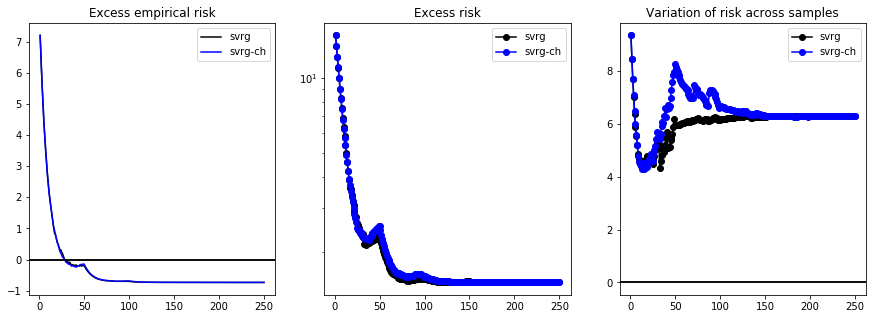

In [7]:
## Visualization of performance.

tvals = np.arange(t_max)+1 # better to start from the first update.

# Average over trials.
myfig = plt.figure(figsize=(15,5))

ax_loss_tr = myfig.add_subplot(1, 3, 1)
for m in m_idx_todo:
    vals = ave_loss_tr[:,m]
    err = sd_loss_tr[:,m]
    ax_loss_tr.plot(tvals, vals, color=mth_colours[m], label=mth_names[m])
    #ax_loss_tr.errorbar(tvals, vals, yerr=err, fmt='-o', col=mth_colours[m], label=mth_names[m])
    ax_loss_tr.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess empirical risk")
    

ax_riskvals = myfig.add_subplot(1, 3, 2)
for m in m_idx_todo:
    vals = ave_riskvals[:,m]
    err = sd_riskvals[:,m]
    err_log = err / vals
    ax_riskvals.semilogy(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_riskvals.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Excess risk")

ax_variation = myfig.add_subplot(1, 3, 3)
for m in m_idx_todo:
    vals = sd_riskvals[:,m]
    ax_variation.plot(tvals, vals, "-o", color=mth_colours[m], label=mth_names[m])
    ax_variation.legend(loc=1,ncol=1)
    plt.axhline(y=0.0, color="black")
    plt.title("Variation of risk across samples")


plt.show()

Great. The behaviour is essentially the same. Since the bootstrapped samples are selected randomly and independently across the two implementations, there is naturally some minor deviation in behaviour, but on the whole they perform identically, verifying with relative certainty that the Chainer-based optimizer indeed behaves as we would expect.

___

<a id="experiment"></a>
## Overview of numerical experiments

In this section, we dig in to the numerical experiments of Johnson and Zhang (2013). In the following section, we will actually implement the various experiments. Their experiments involve several real-world data sets, all well-known benchmarks used frequently in machine learning. In particular, they evaluate three quantities:

- Training loss
- Testing loss
- Update variance

These quantities are evaluated as a function of *cost*, which is the number of $d$-dimensional gradient vectors computed. The basic form of their results is as below:

<img src="img/JZ_exps_example.png"  alt="Example figures from Johnson and Zhang (NIPS 2013)" />


Their experimental setup considers *classification* tasks only.
They basically consider two distinct experimental settings, exploring the same data sets under both settings:

- Convex: traditional logistic regression is used; the objective is a convex function in the linear weights.
- Non-convex: a feed-forward neural network with one fully-connected hidden layer, sigmoid activation, and softmax output nodes for each class. The mini-batch size is 10. The resulting logistic regression is not convex as a function of the network weights.

On variance computation:

> In Fig. 2 (c), we show the variance of SVRG update $-\eta (\nabla \psi_{i}(w)-\psi_{i}(\tilde{w})+\tilde{\mu})$ in comparison with the variance of SGD update $-\eta(\nabla \psi_{i}(w))$ and SDCA. As expected, the variance (including multiplication with the learning rate) of both SVRG and SDCA decreases as optimization proceeds, and the variance of SGD with a fixed learning rate (‘SGD:0.001’) stays high.

Some key additional facts:

- Inner loop max iterations: $2n$ (convex) and $5n$ (non-convex).

- Initialization of SVRG: by running SGD for one epoch (convex) or ten epochs (non-convex).

- All tests used $\ell_{2}$ norm-based regularization, with weights depending on the data set used: 1e-4 for MNIST, 1e-3 for CIFAR-10, in both convex and non-convex settings.

- Learning rates are displayed in the papers in the Figure.

___

<a href="#testing"></a>
## Testing and empirical analysis

Here is where we run the actual experiments. Below, we have completed preliminary implementations of SVRG in the convex (multi-class logistic regression) and non-convex (feed-forward neural network + softmax) cases. Using this code as a guide, carry out the following __exercises__:

0. Parameters such as learning rate, regularization weight, number of inner/outer loop iteration etc., are set arbitrarily in the code below. Modify these to match the paper.

0. In the non-convex case, we have only implemented SVRG. Implement SGD in the non-convex case and compare performance.

0. How has $\ell_{2}$ norm-based regularization been implemented in our non-convex implementation?

0. How is "variance" computed in our non-convex implementation?

0. Learning rate scheduling for SGD has not been implemented (only fixed learning rates); implement this and compute the performance of what they call "SGD-best" (based on a grid of hyper-parameters).

In [19]:
import os
import math
import tables
import numpy as np
import multiprocessing as mltp
import chainer as ch

import algorithms
import models
import models_ch
import dataclass
import helpers as hlp

In [20]:
# Data set choice.

paths = {
    "cifar10": os.path.join("data", "cifar10", "data.h5"),
    "mnist": os.path.join("data", "mnist", "data.h5"),
    "iris": os.path.join("data", "iris", "data.h5")
}

task_name = "mnist" #"iris" # SET BY HAND.

In [21]:
# General-purpose performance evaluation.
def perf_fn(model=None, algo=None, data=None):
    '''
    Performance measurement routine.
    Various metrics are computed, relevant descriptions
    are given as names, and both are returned together
    in a dictionary.
    '''

    names = ["Misclass rate (train)",
             "Misclass rate (test)",
             "Primal objective (train)",
             "Primal objective (test)",
             "Norm (l2)"]

    # In the case of a dry run, leave perf Null.
    if ((model is None) or (algo is None)):
        return {"names": names, "perf": None}

    # Else, compute the performance metrics of interest.
    y_est_tr = model.classify(w=algo.w, X=data.X_tr)
    y_est_te = model.classify(w=algo.w, X=data.X_te)

    perf_tr = model.class_perf(y_est=y_est_tr, y_true=data.y_tr)
    perf_te = model.class_perf(y_est=y_est_te, y_true=data.y_te)

    misclass_tr = perf_tr["rate"]
    misclass_te = perf_te["rate"]
    
    primal_tr = np.mean(model.l_tr(w=algo.w, data=data))
    primal_te = np.mean(model.l_te(w=algo.w, data=data))

    w_norm = np.linalg.norm(algo.w)
    
    perf = np.array([misclass_tr, misclass_te,
                     primal_tr, primal_te,
                     w_norm])
    
    out = {"names": names,
           "perf": perf}
    
    return out


# Performance evaluation for Chainer-based implementation.
def perf_fn_ch(model=None, data=None):
    '''
    Performance measurement routine; Chainer version.
    Various metrics are computed, relevant descriptions
    are given as names, and both are returned together
    in a dictionary.
    
    NOTE: the "model" here contains all parameters.
    '''
    
    names = ["Misclass rate (train)",
             "Misclass rate (test)",
             "Primal objective (train)",
             "Primal objective (test)",
             "Norm (l2)"]

    # In the case of a dry run, leave perf Null.
    if (model is None or data is None):
        return {"names": names, "perf": None}

    # Else, compute the performance metrics of interest.
    
    ## Get predictions (not tuple notation).
    prediction_tr = model(data.X_tr)
    prediction_te = model(data.X_te)
    
    ## Compute misclassification rate.
    accuracy_tr = ch.functions.accuracy(y=prediction_tr,
                                        t=np.int8(data.y_tr).flatten()).data
    accuracy_te = ch.functions.accuracy(y=prediction_te,
                                        t=np.int8(data.y_te).flatten()).data
    misclass_tr = 1-accuracy_tr
    misclass_te = 1-accuracy_te
    
    ## Compute loss function values.
    primal_tr = ch.functions.softmax_cross_entropy(x=prediction_tr,
                                                   t=np.int8(data.y_tr).flatten(),
                                                   normalize=True,
                                                   reduce="mean").data
    
    primal_te = ch.functions.softmax_cross_entropy(x=prediction_te,
                                                   t=np.int8(data.y_te).flatten(),
                                                   normalize=True,
                                                   reduce="mean").data
    
    ## Finally compute the norm.
    w_norm = 0
    for p in model.params():
        w_norm += np.linalg.norm(p.data)**2
    w_norm = math.sqrt(w_norm)
    
    
    perf = np.array([misclass_tr, misclass_te,
                     primal_tr, primal_te,
                     w_norm])
    
    out = {"names": names,
           "perf": perf}
    
    return out

<a id="testing_linear"></a>
### Running linear models ("convex" case)


In [13]:
# Basically a "driver script" for our hand-built guys.

num_trials = 5

# Prepare a results folder, if doesn't already exist.
hlp.makedir_safe(os.path.join("results", task_name))

# Establish file connection.
toread = paths[task_name]
f = tables.open_file(toread, mode="r")

# Prepare data object.
data = dataclass.DataSet()
data.init_tr(X=f.root.train.inputs.read(),
             y=f.root.train.labels.read())
data.init_te(X=f.root.test.inputs.read(),
             y=f.root.test.labels.read())

In [14]:
# Prepare model object.
mod = models.LogisticReg(data=data)

# Initialize all competing hand-built algorithms.
n, numfeats = data.X_tr.shape
nc = mod.nc
d = numfeats * (nc-1)

In [15]:
perf_names = perf_fn()["names"] # fire a blank to get metric names.
num_metrics = len(perf_names) # number of perf metrics used.

In [16]:
# Algorithm preparation.

num_epochs = 10
replace = False
thres = 1e-03
store = False
lamreg = 1e-03 # should adjust depending on data set.

def alpha_fixed(t, val):
    return val

def make_step(u):
    def mystep(t, model=None, data=None, newdir=None):
        return alpha_fixed(t=t, val=u)
    return mystep

def algoFn_sgd(w_init):
    al = algorithms.Algo_SGD(w_init=w_init,
                             step=make_step(u=0.01),
                             batchsize=1,
                             replace=replace,
                             t_max=num_epochs*n,
                             thres=thres,
                             store=store,
                             lamreg=lamreg)
    return al

def algoFn_svrg(w_init):
    al = algorithms.Algo_SVRG(w_init=w_init,
                              step=make_step(u=0.1),
                              batchsize=1,
                              replace=replace,
                              out_max=num_epochs/2,
                              in_max=2*n,
                              thres=thres,
                              store=store,
                              lamreg=lamreg)
    return al

algoFn_dict = {"sgd": algoFn_svrg,
               "svrg": algoFn_sgd}

In [17]:
# Max number of perf records.
max_records = num_epochs + 1 # extra one for initial values.

In [18]:
# Run the algorithms, and write performance to disk.

def worker(algorithm_name):
    
    print("At work:", algorithm_name)
    
    # Array used for recording cumulative costs.
    perf_cumcost = np.zeros(max_records, dtype=np.uint32)
    perf_cumcost.fill(np.nan)

    # Array used for recording update variance.
    perf_updatevar = np.zeros(max_records, dtype=np.float32)
    perf_updatevar.fill(np.nan)

    # Array used for housing performance over trials.
    perf_array = np.zeros((max_records, num_metrics, num_trials),
                          dtype=np.float32)
    perf_array.fill(np.nan)
    
    for tri in range(num_trials):

        # Initialize weights and algorithm here.
        w_init = np.random.uniform(low=0.0, high=0.1, size=(d,1))
        al = algoFn_dict[algorithm_name](w_init=w_init)

        cntr = 0
        for onestep in al:

            if al.t % 5000 == 0:
                print("Update: t =", al.t)

            al.update(model=mod, data=data) # update parameters.

            if al.torecord:
                al.torecord = False # switch off.
                perf_updatevar[cntr] = al.diff
                perf_array[cntr,:,tri] = perf_fn(model=mod,
                                                 algo=al,
                                                 data=data)["perf"]
                perf_cumcost[cntr] = al.cumcost
                cntr += 1

        # Finally, if cntr isn't already maxed out, be sure
        # to record performance at the final step.
        if cntr < max_records:
            perf_updatevar[cntr] = np.linalg.norm(al.w-al.w_old)
            perf_array[cntr,:,tri] = perf_fn(model=mod,
                                             algo=al,
                                             data=data)["perf"]
            perf_cumcost[cntr] = al.cumcost

    # Having run over all trials, compute statistics.
    # note: ndarray shape is (max_records, num_metrics).
    perf_ave = np.mean(perf_array, axis=2)
    perf_sd = np.std(perf_array, axis=2)

    # Trim the unfilled results (as needed).
    tocheck = np.where(np.isnan(perf_ave[:,0]))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_ave = perf_ave[0:badidx,:]

    tocheck = np.where(np.isnan(perf_sd[:,0]))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_sd = perf_sd[0:badidx,:]

    tocheck = np.where(np.isnan(perf_cumcost))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_cumcost = perf_cumcost[0:badidx,:]

    tocheck = np.where(np.isnan(perf_updatevar))[0]
    if tocheck.size > 0:
        badidx = tocheck[0]
        perf_updatevar = perf_updatevar[0:badidx]

    # Write to disk.
    towrite = os.path.join("results", task_name)
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".cost")),
               X=perf_cumcost, fmt="%d", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".upvar")),
               X=perf_updatevar, fmt="%.7e", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".ave")),
               X=perf_ave, fmt="%.7e", delimiter=",")
    np.savetxt(fname=os.path.join(towrite, (algorithm_name+".sd")),
               X=perf_sd, fmt="%.7e", delimiter=",")


In [19]:
if __name__ == "__main__":
    cpu_count = mltp.cpu_count()
    print("Our machine has", cpu_count, "CPUs.")
    print("Of these,", len(os.sched_getaffinity(0)), "are available.")
            
    # Put all processors to work (at an upper limit).
    mypool = mltp.Pool(cpu_count)
    
    # Pass the "worker" the name of the algorithm to run.
    mypool.map(func=worker, iterable=algoFn_dict.keys())

    # Memory management.
    mypool.close() # important for stopping memory leaks.
    mypool.join() # wait for all workers to exit.
    
    # END of multiproc procedure.

Our machine has 12 CPUs.
Of these, 12 are available.
At work: svrg
At work: sgd
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0
Update: t = 0


In [20]:
# Close file connection.
f.close()

<a id="testing_nonlinear"></a>
### Running non-linear models ("non-convex" case)

Here is where we do essentially the same thing as above, except instead of using our customized models and optimizers, we make use of Chainer to expediate the implementation process.

Let's implement their non-linear model, in the sub-class `Chain_JZ`.

In [22]:
class Chain_JZ(ch.Chain):
    '''
    The neural network used by Johnson and Zhang (2013).
    '''
    
    def __init__(self,
                 out_l0,
                 out_l1,
                 out_l2,
                 init_delta=1.0,
                 nobias=False):
        super(Chain_JZ, self).__init__()
        
        with self.init_scope():
            self.l1 = models_ch.Linear(in_size=out_l0,
                                       out_size=out_l1,
                                       init_W=None,
                                       init_b=None,
                                       init_delta=init_delta,
                                       nobias=True)
            self.l2 = models_ch.Linear(in_size=out_l1,
                                       out_size=out_l2,
                                       init_W=None,
                                       init_b=None,
                                       init_delta=init_delta,
                                       nobias=True)
        
    def __call__(self, x):
        out = ch.functions.sigmoid(self.l1(x)) # logistic sigmoid.
        out = self.l2(out) # return the un-normalized log-probabilities.
        return out

In [23]:
# Basically a "driver script" for our CHAINER-built guys.

num_trials = 1

# Prepare a results folder, if doesn't already exist.
hlp.makedir_safe(os.path.join("results", task_name))

# Establish file connection.
toread = paths[task_name]
f = tables.open_file(toread, mode="r")
    
# Prepare data object for Chainer.
Z_tr = ch.datasets.TupleDataset(np.float32(f.root.train.inputs.read()),
                                np.int8(f.root.train.labels.read()))

data = dataclass.DataSet()
data.init_tr(X=f.root.train.inputs.read(),
             y=f.root.train.labels.read())
data.init_te(X=f.root.test.inputs.read(),
             y=f.root.test.labels.read())

In [24]:
n, numfeats = data.X_tr.shape
nc = len(np.unique(data.y_tr))
d = numfeats * (nc-1)

In [25]:
perf_names = perf_fn_ch()["names"] # fire a blank to get metric names.
num_metrics = len(perf_names) # number of perf metrics used.

In [26]:
# Algorithm preparation.
num_epochs = 1
replace = False
thres = 1e-03
store = False
lamreg = 1e-03 # should adjust depending on data set.
alphaval = 0.05

in_max = n
out_max = num_epochs
t_max = out_max * in_max

al_name = "svrg-ch"

In [27]:
# Max number of perf records.
max_records = num_epochs + 1 # extra one for initial values.

In [28]:
# Run the algorithms, and write performance to disk.

# Array used for recording cumulative costs.
perf_cumcost = np.empty(max_records)
perf_cumcost.fill(np.nan)

# Array used for recording update variance.
perf_updatevar = np.empty(max_records)
perf_updatevar.fill(np.nan)

# Array used for housing performance over trials.
perf_array = np.zeros((max_records, num_metrics, num_trials))
perf_array.fill(np.nan)

for tri in range(num_trials):
    
    print("Preparation of algorithm...")
    print("Trial =", tri)
    
    # Initialize models (Chainer-based).
    mod_svrg = Chain_JZ(out_l0=numfeats,
                        out_l1=100,
                        out_l2=nc,
                        nobias=True)
    
    mod_snap = Chain_JZ(out_l0=numfeats,
                        out_l1=100,
                        out_l2=nc,
                        nobias=True)
    
    # Execution of SVRG.
    idx = 0
    cntr = 0
    cumcost = 0
    t = 0
    iter_train = ch.iterators.SerialIterator(dataset=Z_tr,
                                             batch_size=1,
                                             repeat=True,
                                             shuffle=True)
    
    while t < t_max:
        
        print("t value =", t)
        
        # If condition holds, run "outer loop" update.
        if t % in_max == 0:
            
            # Turn on the "to record" flag.
            torecord = True
            
            # Use the output of "inner loop" as new snapshot.
            mod_snap = mod_svrg.copy(mode="copy")
            
            # Use the full data set here.
            prediction_tr_snap = mod_snap(data.X_tr)

            # Compute loss and full-batch gradient.
            loss_snap = ch.functions.softmax_cross_entropy(x=prediction_tr_snap,
                                                           t=np.int8(data.y_tr).flatten(),
                                                           normalize=True,
                                                           reduce="mean")
            mod_snap.cleargrads()
            loss_snap.backward()
            
            # Store the gradient list for use in inner loop.
            grad_list = [np.copy(p.grad) for p in mod_snap.params()]
            
            # Update cumulative cost.
            cumcost += data.X_tr.shape[0]
        
        # In any case, run typical "inner loop" update.
        
        ## Mini-batch computations for inner loop.
        Z = iter_train.next()
        X, y = ch.dataset.concat_examples(Z)
        t += 1 # manage steps ourselves.
        
        ## Predictions.
        prediction_tr = mod_svrg(X)
        prediction_tr_snap = mod_snap(X)
        
        ## Loss computations (will feed the grad computations).
        loss = ch.functions.softmax_cross_entropy(x=prediction_tr,
                                                  t=y.flatten(),
                                                  normalize=True,
                                                  reduce="mean")
        
        loss_snap = ch.functions.softmax_cross_entropy(x=prediction_tr_snap,
                                                       t=y.flatten(),
                                                       normalize=True,
                                                       reduce="mean")
        
        ## Gradient computations.
        mod_svrg.cleargrads()
        mod_snap.cleargrads()
        loss.backward()
        loss_snap.backward()
        
        ## Update cumulative cost.
        cumcost += 2
        
        # Prepare fresh update variance (squared).
        upvar_sq = 0 
        
        ## Parameter updates.
        zipped = zip(mod_svrg.params(), mod_snap.params(), grad_list)
        for p, p_snap, mu in zipped:
            grad = p.grad
            grad_snap = p_snap.grad
            if grad is None:
                continue
            else:
                adjust = grad_snap - mu
                p.data *= (1-2*lamreg*alphaval) # this is l2-squared regularization.
                p.data -= alphaval * (grad-adjust)
                upvar_sq += np.linalg.norm(alphaval*(grad-adjust))**2
        
        ## Record performance.
        if torecord:
            torecord = False # switch off.
            perf_updatevar[cntr] = math.sqrt(upvar_sq)
            perf_array[cntr,:,tri] = perf_fn_ch(
                model=mod_svrg,
                data=data
            )["perf"]
            perf_cumcost[cntr] = cumcost
            cntr += 1
            
            
# Having run over all trials, compute statistics.
# note: ndarray shape is (max_records, num_metrics).
perf_ave = np.mean(perf_array, axis=2)
perf_sd = np.std(perf_array, axis=2)

# Trim the unfilled results (as needed).
tocheck = np.where(np.isnan(perf_ave[:,0]))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_ave = np.float32(perf_ave[0:badidx,:])

tocheck = np.where(np.isnan(perf_sd[:,0]))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_sd = np.float32(perf_sd[0:badidx,:])

tocheck = np.where(np.isnan(perf_cumcost))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_cumcost = np.uint32(perf_cumcost[0:badidx])

tocheck = np.where(np.isnan(perf_updatevar))[0]
if tocheck.size > 0:
    badidx = tocheck[0]
    perf_updatevar = np.float32(perf_updatevar[0:badidx])

# Write to disk.
towrite = os.path.join("results", task_name)
np.savetxt(fname=os.path.join(towrite, (al_name+".cost")),
            X=perf_cumcost, fmt="%d", delimiter=",")
np.savetxt(fname=os.path.join(towrite, (al_name+".upvar")),
            X=perf_updatevar, fmt="%.7e", delimiter=",")
np.savetxt(fname=os.path.join(towrite, (al_name+".ave")),
            X=perf_ave, fmt="%.7e", delimiter=",")
np.savetxt(fname=os.path.join(towrite, (al_name+".sd")),
           X=perf_sd, fmt="%.7e", delimiter=",")



Preparation of algorithm...
Trial = 0
t value = 0
t value = 1
t value = 2
t value = 3
t value = 4
t value = 5
t value = 6
t value = 7
t value = 8
t value = 9
t value = 10
t value = 11
t value = 12
t value = 13
t value = 14
t value = 15
t value = 16
t value = 17
t value = 18
t value = 19
t value = 20
t value = 21
t value = 22
t value = 23
t value = 24
t value = 25
t value = 26
t value = 27
t value = 28
t value = 29
t value = 30
t value = 31
t value = 32
t value = 33
t value = 34
t value = 35
t value = 36
t value = 37
t value = 38
t value = 39
t value = 40
t value = 41
t value = 42
t value = 43
t value = 44
t value = 45
t value = 46
t value = 47
t value = 48
t value = 49
t value = 50
t value = 51
t value = 52
t value = 53
t value = 54
t value = 55
t value = 56
t value = 57
t value = 58
t value = 59
t value = 60
t value = 61
t value = 62
t value = 63
t value = 64
t value = 65
t value = 66
t value = 67
t value = 68
t value = 69
t value = 70
t value = 71
t value = 72
t value = 73
t value = 

t value = 627
t value = 628
t value = 629
t value = 630
t value = 631
t value = 632
t value = 633
t value = 634
t value = 635
t value = 636
t value = 637
t value = 638
t value = 639
t value = 640
t value = 641
t value = 642
t value = 643
t value = 644
t value = 645
t value = 646
t value = 647
t value = 648
t value = 649
t value = 650
t value = 651
t value = 652
t value = 653
t value = 654
t value = 655
t value = 656
t value = 657
t value = 658
t value = 659
t value = 660
t value = 661
t value = 662
t value = 663
t value = 664
t value = 665
t value = 666
t value = 667
t value = 668
t value = 669
t value = 670
t value = 671
t value = 672
t value = 673
t value = 674
t value = 675
t value = 676
t value = 677
t value = 678
t value = 679
t value = 680
t value = 681
t value = 682
t value = 683
t value = 684
t value = 685
t value = 686
t value = 687
t value = 688
t value = 689
t value = 690
t value = 691
t value = 692
t value = 693
t value = 694
t value = 695
t value = 696
t value = 697
t valu

t value = 1306
t value = 1307
t value = 1308
t value = 1309
t value = 1310
t value = 1311
t value = 1312
t value = 1313
t value = 1314
t value = 1315
t value = 1316
t value = 1317
t value = 1318
t value = 1319
t value = 1320
t value = 1321
t value = 1322
t value = 1323
t value = 1324
t value = 1325
t value = 1326
t value = 1327
t value = 1328
t value = 1329
t value = 1330
t value = 1331
t value = 1332
t value = 1333
t value = 1334
t value = 1335
t value = 1336
t value = 1337
t value = 1338
t value = 1339
t value = 1340
t value = 1341
t value = 1342
t value = 1343
t value = 1344
t value = 1345
t value = 1346
t value = 1347
t value = 1348
t value = 1349
t value = 1350
t value = 1351
t value = 1352
t value = 1353
t value = 1354
t value = 1355
t value = 1356
t value = 1357
t value = 1358
t value = 1359
t value = 1360
t value = 1361
t value = 1362
t value = 1363
t value = 1364
t value = 1365
t value = 1366
t value = 1367
t value = 1368
t value = 1369
t value = 1370
t value = 1371
t value = 

t value = 1863
t value = 1864
t value = 1865
t value = 1866
t value = 1867
t value = 1868
t value = 1869
t value = 1870
t value = 1871
t value = 1872
t value = 1873
t value = 1874
t value = 1875
t value = 1876
t value = 1877
t value = 1878
t value = 1879
t value = 1880
t value = 1881
t value = 1882
t value = 1883
t value = 1884
t value = 1885
t value = 1886
t value = 1887
t value = 1888
t value = 1889
t value = 1890
t value = 1891
t value = 1892
t value = 1893
t value = 1894
t value = 1895
t value = 1896
t value = 1897
t value = 1898
t value = 1899
t value = 1900
t value = 1901
t value = 1902
t value = 1903
t value = 1904
t value = 1905
t value = 1906
t value = 1907
t value = 1908
t value = 1909
t value = 1910
t value = 1911
t value = 1912
t value = 1913
t value = 1914
t value = 1915
t value = 1916
t value = 1917
t value = 1918
t value = 1919
t value = 1920
t value = 1921
t value = 1922
t value = 1923
t value = 1924
t value = 1925
t value = 1926
t value = 1927
t value = 1928
t value = 

t value = 2439
t value = 2440
t value = 2441
t value = 2442
t value = 2443
t value = 2444
t value = 2445
t value = 2446
t value = 2447
t value = 2448
t value = 2449
t value = 2450
t value = 2451
t value = 2452
t value = 2453
t value = 2454
t value = 2455
t value = 2456
t value = 2457
t value = 2458
t value = 2459
t value = 2460
t value = 2461
t value = 2462
t value = 2463
t value = 2464
t value = 2465
t value = 2466
t value = 2467
t value = 2468
t value = 2469
t value = 2470
t value = 2471
t value = 2472
t value = 2473
t value = 2474
t value = 2475
t value = 2476
t value = 2477
t value = 2478
t value = 2479
t value = 2480
t value = 2481
t value = 2482
t value = 2483
t value = 2484
t value = 2485
t value = 2486
t value = 2487
t value = 2488
t value = 2489
t value = 2490
t value = 2491
t value = 2492
t value = 2493
t value = 2494
t value = 2495
t value = 2496
t value = 2497
t value = 2498
t value = 2499
t value = 2500
t value = 2501
t value = 2502
t value = 2503
t value = 2504
t value = 

t value = 3098
t value = 3099
t value = 3100
t value = 3101
t value = 3102
t value = 3103
t value = 3104
t value = 3105
t value = 3106
t value = 3107
t value = 3108
t value = 3109
t value = 3110
t value = 3111
t value = 3112
t value = 3113
t value = 3114
t value = 3115
t value = 3116
t value = 3117
t value = 3118
t value = 3119
t value = 3120
t value = 3121
t value = 3122
t value = 3123
t value = 3124
t value = 3125
t value = 3126
t value = 3127
t value = 3128
t value = 3129
t value = 3130
t value = 3131
t value = 3132
t value = 3133
t value = 3134
t value = 3135
t value = 3136
t value = 3137
t value = 3138
t value = 3139
t value = 3140
t value = 3141
t value = 3142
t value = 3143
t value = 3144
t value = 3145
t value = 3146
t value = 3147
t value = 3148
t value = 3149
t value = 3150
t value = 3151
t value = 3152
t value = 3153
t value = 3154
t value = 3155
t value = 3156
t value = 3157
t value = 3158
t value = 3159
t value = 3160
t value = 3161
t value = 3162
t value = 3163
t value = 

t value = 3690
t value = 3691
t value = 3692
t value = 3693
t value = 3694
t value = 3695
t value = 3696
t value = 3697
t value = 3698
t value = 3699
t value = 3700
t value = 3701
t value = 3702
t value = 3703
t value = 3704
t value = 3705
t value = 3706
t value = 3707
t value = 3708
t value = 3709
t value = 3710
t value = 3711
t value = 3712
t value = 3713
t value = 3714
t value = 3715
t value = 3716
t value = 3717
t value = 3718
t value = 3719
t value = 3720
t value = 3721
t value = 3722
t value = 3723
t value = 3724
t value = 3725
t value = 3726
t value = 3727
t value = 3728
t value = 3729
t value = 3730
t value = 3731
t value = 3732
t value = 3733
t value = 3734
t value = 3735
t value = 3736
t value = 3737
t value = 3738
t value = 3739
t value = 3740
t value = 3741
t value = 3742
t value = 3743
t value = 3744
t value = 3745
t value = 3746
t value = 3747
t value = 3748
t value = 3749
t value = 3750
t value = 3751
t value = 3752
t value = 3753
t value = 3754
t value = 3755
t value = 

t value = 4292
t value = 4293
t value = 4294
t value = 4295
t value = 4296
t value = 4297
t value = 4298
t value = 4299
t value = 4300
t value = 4301
t value = 4302
t value = 4303
t value = 4304
t value = 4305
t value = 4306
t value = 4307
t value = 4308
t value = 4309
t value = 4310
t value = 4311
t value = 4312
t value = 4313
t value = 4314
t value = 4315
t value = 4316
t value = 4317
t value = 4318
t value = 4319
t value = 4320
t value = 4321
t value = 4322
t value = 4323
t value = 4324
t value = 4325
t value = 4326
t value = 4327
t value = 4328
t value = 4329
t value = 4330
t value = 4331
t value = 4332
t value = 4333
t value = 4334
t value = 4335
t value = 4336
t value = 4337
t value = 4338
t value = 4339
t value = 4340
t value = 4341
t value = 4342
t value = 4343
t value = 4344
t value = 4345
t value = 4346
t value = 4347
t value = 4348
t value = 4349
t value = 4350
t value = 4351
t value = 4352
t value = 4353
t value = 4354
t value = 4355
t value = 4356
t value = 4357
t value = 

t value = 4843
t value = 4844
t value = 4845
t value = 4846
t value = 4847
t value = 4848
t value = 4849
t value = 4850
t value = 4851
t value = 4852
t value = 4853
t value = 4854
t value = 4855
t value = 4856
t value = 4857
t value = 4858
t value = 4859
t value = 4860
t value = 4861
t value = 4862
t value = 4863
t value = 4864
t value = 4865
t value = 4866
t value = 4867
t value = 4868
t value = 4869
t value = 4870
t value = 4871
t value = 4872
t value = 4873
t value = 4874
t value = 4875
t value = 4876
t value = 4877
t value = 4878
t value = 4879
t value = 4880
t value = 4881
t value = 4882
t value = 4883
t value = 4884
t value = 4885
t value = 4886
t value = 4887
t value = 4888
t value = 4889
t value = 4890
t value = 4891
t value = 4892
t value = 4893
t value = 4894
t value = 4895
t value = 4896
t value = 4897
t value = 4898
t value = 4899
t value = 4900
t value = 4901
t value = 4902
t value = 4903
t value = 4904
t value = 4905
t value = 4906
t value = 4907
t value = 4908
t value = 

t value = 5473
t value = 5474
t value = 5475
t value = 5476
t value = 5477
t value = 5478
t value = 5479
t value = 5480
t value = 5481
t value = 5482
t value = 5483
t value = 5484
t value = 5485
t value = 5486
t value = 5487
t value = 5488
t value = 5489
t value = 5490
t value = 5491
t value = 5492
t value = 5493
t value = 5494
t value = 5495
t value = 5496
t value = 5497
t value = 5498
t value = 5499
t value = 5500
t value = 5501
t value = 5502
t value = 5503
t value = 5504
t value = 5505
t value = 5506
t value = 5507
t value = 5508
t value = 5509
t value = 5510
t value = 5511
t value = 5512
t value = 5513
t value = 5514
t value = 5515
t value = 5516
t value = 5517
t value = 5518
t value = 5519
t value = 5520
t value = 5521
t value = 5522
t value = 5523
t value = 5524
t value = 5525
t value = 5526
t value = 5527
t value = 5528
t value = 5529
t value = 5530
t value = 5531
t value = 5532
t value = 5533
t value = 5534
t value = 5535
t value = 5536
t value = 5537
t value = 5538
t value = 

t value = 6022
t value = 6023
t value = 6024
t value = 6025
t value = 6026
t value = 6027
t value = 6028
t value = 6029
t value = 6030
t value = 6031
t value = 6032
t value = 6033
t value = 6034
t value = 6035
t value = 6036
t value = 6037
t value = 6038
t value = 6039
t value = 6040
t value = 6041
t value = 6042
t value = 6043
t value = 6044
t value = 6045
t value = 6046
t value = 6047
t value = 6048
t value = 6049
t value = 6050
t value = 6051
t value = 6052
t value = 6053
t value = 6054
t value = 6055
t value = 6056
t value = 6057
t value = 6058
t value = 6059
t value = 6060
t value = 6061
t value = 6062
t value = 6063
t value = 6064
t value = 6065
t value = 6066
t value = 6067
t value = 6068
t value = 6069
t value = 6070
t value = 6071
t value = 6072
t value = 6073
t value = 6074
t value = 6075
t value = 6076
t value = 6077
t value = 6078
t value = 6079
t value = 6080
t value = 6081
t value = 6082
t value = 6083
t value = 6084
t value = 6085
t value = 6086
t value = 6087
t value = 

t value = 6609
t value = 6610
t value = 6611
t value = 6612
t value = 6613
t value = 6614
t value = 6615
t value = 6616
t value = 6617
t value = 6618
t value = 6619
t value = 6620
t value = 6621
t value = 6622
t value = 6623
t value = 6624
t value = 6625
t value = 6626
t value = 6627
t value = 6628
t value = 6629
t value = 6630
t value = 6631
t value = 6632
t value = 6633
t value = 6634
t value = 6635
t value = 6636
t value = 6637
t value = 6638
t value = 6639
t value = 6640
t value = 6641
t value = 6642
t value = 6643
t value = 6644
t value = 6645
t value = 6646
t value = 6647
t value = 6648
t value = 6649
t value = 6650
t value = 6651
t value = 6652
t value = 6653
t value = 6654
t value = 6655
t value = 6656
t value = 6657
t value = 6658
t value = 6659
t value = 6660
t value = 6661
t value = 6662
t value = 6663
t value = 6664
t value = 6665
t value = 6666
t value = 6667
t value = 6668
t value = 6669
t value = 6670
t value = 6671
t value = 6672
t value = 6673
t value = 6674
t value = 

t value = 7211
t value = 7212
t value = 7213
t value = 7214
t value = 7215
t value = 7216
t value = 7217
t value = 7218
t value = 7219
t value = 7220
t value = 7221
t value = 7222
t value = 7223
t value = 7224
t value = 7225
t value = 7226
t value = 7227
t value = 7228
t value = 7229
t value = 7230
t value = 7231
t value = 7232
t value = 7233
t value = 7234
t value = 7235
t value = 7236
t value = 7237
t value = 7238
t value = 7239
t value = 7240
t value = 7241
t value = 7242
t value = 7243
t value = 7244
t value = 7245
t value = 7246
t value = 7247
t value = 7248
t value = 7249
t value = 7250
t value = 7251
t value = 7252
t value = 7253
t value = 7254
t value = 7255
t value = 7256
t value = 7257
t value = 7258
t value = 7259
t value = 7260
t value = 7261
t value = 7262
t value = 7263
t value = 7264
t value = 7265
t value = 7266
t value = 7267
t value = 7268
t value = 7269
t value = 7270
t value = 7271
t value = 7272
t value = 7273
t value = 7274
t value = 7275
t value = 7276
t value = 

t value = 7790
t value = 7791
t value = 7792
t value = 7793
t value = 7794
t value = 7795
t value = 7796
t value = 7797
t value = 7798
t value = 7799
t value = 7800
t value = 7801
t value = 7802
t value = 7803
t value = 7804
t value = 7805
t value = 7806
t value = 7807
t value = 7808
t value = 7809
t value = 7810
t value = 7811
t value = 7812
t value = 7813
t value = 7814
t value = 7815
t value = 7816
t value = 7817
t value = 7818
t value = 7819
t value = 7820
t value = 7821
t value = 7822
t value = 7823
t value = 7824
t value = 7825
t value = 7826
t value = 7827
t value = 7828
t value = 7829
t value = 7830
t value = 7831
t value = 7832
t value = 7833
t value = 7834
t value = 7835
t value = 7836
t value = 7837
t value = 7838
t value = 7839
t value = 7840
t value = 7841
t value = 7842
t value = 7843
t value = 7844
t value = 7845
t value = 7846
t value = 7847
t value = 7848
t value = 7849
t value = 7850
t value = 7851
t value = 7852
t value = 7853
t value = 7854
t value = 7855
t value = 

t value = 8435
t value = 8436
t value = 8437
t value = 8438
t value = 8439
t value = 8440
t value = 8441
t value = 8442
t value = 8443
t value = 8444
t value = 8445
t value = 8446
t value = 8447
t value = 8448
t value = 8449
t value = 8450
t value = 8451
t value = 8452
t value = 8453
t value = 8454
t value = 8455
t value = 8456
t value = 8457
t value = 8458
t value = 8459
t value = 8460
t value = 8461
t value = 8462
t value = 8463
t value = 8464
t value = 8465
t value = 8466
t value = 8467
t value = 8468
t value = 8469
t value = 8470
t value = 8471
t value = 8472
t value = 8473
t value = 8474
t value = 8475
t value = 8476
t value = 8477
t value = 8478
t value = 8479
t value = 8480
t value = 8481
t value = 8482
t value = 8483
t value = 8484
t value = 8485
t value = 8486
t value = 8487
t value = 8488
t value = 8489
t value = 8490
t value = 8491
t value = 8492
t value = 8493
t value = 8494
t value = 8495
t value = 8496
t value = 8497
t value = 8498
t value = 8499
t value = 8500
t value = 

t value = 9032
t value = 9033
t value = 9034
t value = 9035
t value = 9036
t value = 9037
t value = 9038
t value = 9039
t value = 9040
t value = 9041
t value = 9042
t value = 9043
t value = 9044
t value = 9045
t value = 9046
t value = 9047
t value = 9048
t value = 9049
t value = 9050
t value = 9051
t value = 9052
t value = 9053
t value = 9054
t value = 9055
t value = 9056
t value = 9057
t value = 9058
t value = 9059
t value = 9060
t value = 9061
t value = 9062
t value = 9063
t value = 9064
t value = 9065
t value = 9066
t value = 9067
t value = 9068
t value = 9069
t value = 9070
t value = 9071
t value = 9072
t value = 9073
t value = 9074
t value = 9075
t value = 9076
t value = 9077
t value = 9078
t value = 9079
t value = 9080
t value = 9081
t value = 9082
t value = 9083
t value = 9084
t value = 9085
t value = 9086
t value = 9087
t value = 9088
t value = 9089
t value = 9090
t value = 9091
t value = 9092
t value = 9093
t value = 9094
t value = 9095
t value = 9096
t value = 9097
t value = 

t value = 9628
t value = 9629
t value = 9630
t value = 9631
t value = 9632
t value = 9633
t value = 9634
t value = 9635
t value = 9636
t value = 9637
t value = 9638
t value = 9639
t value = 9640
t value = 9641
t value = 9642
t value = 9643
t value = 9644
t value = 9645
t value = 9646
t value = 9647
t value = 9648
t value = 9649
t value = 9650
t value = 9651
t value = 9652
t value = 9653
t value = 9654
t value = 9655
t value = 9656
t value = 9657
t value = 9658
t value = 9659
t value = 9660
t value = 9661
t value = 9662
t value = 9663
t value = 9664
t value = 9665
t value = 9666
t value = 9667
t value = 9668
t value = 9669
t value = 9670
t value = 9671
t value = 9672
t value = 9673
t value = 9674
t value = 9675
t value = 9676
t value = 9677
t value = 9678
t value = 9679
t value = 9680
t value = 9681
t value = 9682
t value = 9683
t value = 9684
t value = 9685
t value = 9686
t value = 9687
t value = 9688
t value = 9689
t value = 9690
t value = 9691
t value = 9692
t value = 9693
t value = 

t value = 10212
t value = 10213
t value = 10214
t value = 10215
t value = 10216
t value = 10217
t value = 10218
t value = 10219
t value = 10220
t value = 10221
t value = 10222
t value = 10223
t value = 10224
t value = 10225
t value = 10226
t value = 10227
t value = 10228
t value = 10229
t value = 10230
t value = 10231
t value = 10232
t value = 10233
t value = 10234
t value = 10235
t value = 10236
t value = 10237
t value = 10238
t value = 10239
t value = 10240
t value = 10241
t value = 10242
t value = 10243
t value = 10244
t value = 10245
t value = 10246
t value = 10247
t value = 10248
t value = 10249
t value = 10250
t value = 10251
t value = 10252
t value = 10253
t value = 10254
t value = 10255
t value = 10256
t value = 10257
t value = 10258
t value = 10259
t value = 10260
t value = 10261
t value = 10262
t value = 10263
t value = 10264
t value = 10265
t value = 10266
t value = 10267
t value = 10268
t value = 10269
t value = 10270
t value = 10271
t value = 10272
t value = 10273
t value 

t value = 10778
t value = 10779
t value = 10780
t value = 10781
t value = 10782
t value = 10783
t value = 10784
t value = 10785
t value = 10786
t value = 10787
t value = 10788
t value = 10789
t value = 10790
t value = 10791
t value = 10792
t value = 10793
t value = 10794
t value = 10795
t value = 10796
t value = 10797
t value = 10798
t value = 10799
t value = 10800
t value = 10801
t value = 10802
t value = 10803
t value = 10804
t value = 10805
t value = 10806
t value = 10807
t value = 10808
t value = 10809
t value = 10810
t value = 10811
t value = 10812
t value = 10813
t value = 10814
t value = 10815
t value = 10816
t value = 10817
t value = 10818
t value = 10819
t value = 10820
t value = 10821
t value = 10822
t value = 10823
t value = 10824
t value = 10825
t value = 10826
t value = 10827
t value = 10828
t value = 10829
t value = 10830
t value = 10831
t value = 10832
t value = 10833
t value = 10834
t value = 10835
t value = 10836
t value = 10837
t value = 10838
t value = 10839
t value 

t value = 11362
t value = 11363
t value = 11364
t value = 11365
t value = 11366
t value = 11367
t value = 11368
t value = 11369
t value = 11370
t value = 11371
t value = 11372
t value = 11373
t value = 11374
t value = 11375
t value = 11376
t value = 11377
t value = 11378
t value = 11379
t value = 11380
t value = 11381
t value = 11382
t value = 11383
t value = 11384
t value = 11385
t value = 11386
t value = 11387
t value = 11388
t value = 11389
t value = 11390
t value = 11391
t value = 11392
t value = 11393
t value = 11394
t value = 11395
t value = 11396
t value = 11397
t value = 11398
t value = 11399
t value = 11400
t value = 11401
t value = 11402
t value = 11403
t value = 11404
t value = 11405
t value = 11406
t value = 11407
t value = 11408
t value = 11409
t value = 11410
t value = 11411
t value = 11412
t value = 11413
t value = 11414
t value = 11415
t value = 11416
t value = 11417
t value = 11418
t value = 11419
t value = 11420
t value = 11421
t value = 11422
t value = 11423
t value 

t value = 11947
t value = 11948
t value = 11949
t value = 11950
t value = 11951
t value = 11952
t value = 11953
t value = 11954
t value = 11955
t value = 11956
t value = 11957
t value = 11958
t value = 11959
t value = 11960
t value = 11961
t value = 11962
t value = 11963
t value = 11964
t value = 11965
t value = 11966
t value = 11967
t value = 11968
t value = 11969
t value = 11970
t value = 11971
t value = 11972
t value = 11973
t value = 11974
t value = 11975
t value = 11976
t value = 11977
t value = 11978
t value = 11979
t value = 11980
t value = 11981
t value = 11982
t value = 11983
t value = 11984
t value = 11985
t value = 11986
t value = 11987
t value = 11988
t value = 11989
t value = 11990
t value = 11991
t value = 11992
t value = 11993
t value = 11994
t value = 11995
t value = 11996
t value = 11997
t value = 11998
t value = 11999
t value = 12000
t value = 12001
t value = 12002
t value = 12003
t value = 12004
t value = 12005
t value = 12006
t value = 12007
t value = 12008
t value 

t value = 12567
t value = 12568
t value = 12569
t value = 12570
t value = 12571
t value = 12572
t value = 12573
t value = 12574
t value = 12575
t value = 12576
t value = 12577
t value = 12578
t value = 12579
t value = 12580
t value = 12581
t value = 12582
t value = 12583
t value = 12584
t value = 12585
t value = 12586
t value = 12587
t value = 12588
t value = 12589
t value = 12590
t value = 12591
t value = 12592
t value = 12593
t value = 12594
t value = 12595
t value = 12596
t value = 12597
t value = 12598
t value = 12599
t value = 12600
t value = 12601
t value = 12602
t value = 12603
t value = 12604
t value = 12605
t value = 12606
t value = 12607
t value = 12608
t value = 12609
t value = 12610
t value = 12611
t value = 12612
t value = 12613
t value = 12614
t value = 12615
t value = 12616
t value = 12617
t value = 12618
t value = 12619
t value = 12620
t value = 12621
t value = 12622
t value = 12623
t value = 12624
t value = 12625
t value = 12626
t value = 12627
t value = 12628
t value 

t value = 13182
t value = 13183
t value = 13184
t value = 13185
t value = 13186
t value = 13187
t value = 13188
t value = 13189
t value = 13190
t value = 13191
t value = 13192
t value = 13193
t value = 13194
t value = 13195
t value = 13196
t value = 13197
t value = 13198
t value = 13199
t value = 13200
t value = 13201
t value = 13202
t value = 13203
t value = 13204
t value = 13205
t value = 13206
t value = 13207
t value = 13208
t value = 13209
t value = 13210
t value = 13211
t value = 13212
t value = 13213
t value = 13214
t value = 13215
t value = 13216
t value = 13217
t value = 13218
t value = 13219
t value = 13220
t value = 13221
t value = 13222
t value = 13223
t value = 13224
t value = 13225
t value = 13226
t value = 13227
t value = 13228
t value = 13229
t value = 13230
t value = 13231
t value = 13232
t value = 13233
t value = 13234
t value = 13235
t value = 13236
t value = 13237
t value = 13238
t value = 13239
t value = 13240
t value = 13241
t value = 13242
t value = 13243
t value 

t value = 13784
t value = 13785
t value = 13786
t value = 13787
t value = 13788
t value = 13789
t value = 13790
t value = 13791
t value = 13792
t value = 13793
t value = 13794
t value = 13795
t value = 13796
t value = 13797
t value = 13798
t value = 13799
t value = 13800
t value = 13801
t value = 13802
t value = 13803
t value = 13804
t value = 13805
t value = 13806
t value = 13807
t value = 13808
t value = 13809
t value = 13810
t value = 13811
t value = 13812
t value = 13813
t value = 13814
t value = 13815
t value = 13816
t value = 13817
t value = 13818
t value = 13819
t value = 13820
t value = 13821
t value = 13822
t value = 13823
t value = 13824
t value = 13825
t value = 13826
t value = 13827
t value = 13828
t value = 13829
t value = 13830
t value = 13831
t value = 13832
t value = 13833
t value = 13834
t value = 13835
t value = 13836
t value = 13837
t value = 13838
t value = 13839
t value = 13840
t value = 13841
t value = 13842
t value = 13843
t value = 13844
t value = 13845
t value 

t value = 14298
t value = 14299
t value = 14300
t value = 14301
t value = 14302
t value = 14303
t value = 14304
t value = 14305
t value = 14306
t value = 14307
t value = 14308
t value = 14309
t value = 14310
t value = 14311
t value = 14312
t value = 14313
t value = 14314
t value = 14315
t value = 14316
t value = 14317
t value = 14318
t value = 14319
t value = 14320
t value = 14321
t value = 14322
t value = 14323
t value = 14324
t value = 14325
t value = 14326
t value = 14327
t value = 14328
t value = 14329
t value = 14330
t value = 14331
t value = 14332
t value = 14333
t value = 14334
t value = 14335
t value = 14336
t value = 14337
t value = 14338
t value = 14339
t value = 14340
t value = 14341
t value = 14342
t value = 14343
t value = 14344
t value = 14345
t value = 14346
t value = 14347
t value = 14348
t value = 14349
t value = 14350
t value = 14351
t value = 14352
t value = 14353
t value = 14354
t value = 14355
t value = 14356
t value = 14357
t value = 14358
t value = 14359
t value 

t value = 14913
t value = 14914
t value = 14915
t value = 14916
t value = 14917
t value = 14918
t value = 14919
t value = 14920
t value = 14921
t value = 14922
t value = 14923
t value = 14924
t value = 14925
t value = 14926
t value = 14927
t value = 14928
t value = 14929
t value = 14930
t value = 14931
t value = 14932
t value = 14933
t value = 14934
t value = 14935
t value = 14936
t value = 14937
t value = 14938
t value = 14939
t value = 14940
t value = 14941
t value = 14942
t value = 14943
t value = 14944
t value = 14945
t value = 14946
t value = 14947
t value = 14948
t value = 14949
t value = 14950
t value = 14951
t value = 14952
t value = 14953
t value = 14954
t value = 14955
t value = 14956
t value = 14957
t value = 14958
t value = 14959
t value = 14960
t value = 14961
t value = 14962
t value = 14963
t value = 14964
t value = 14965
t value = 14966
t value = 14967
t value = 14968
t value = 14969
t value = 14970
t value = 14971
t value = 14972
t value = 14973
t value = 14974
t value 

t value = 15502
t value = 15503
t value = 15504
t value = 15505
t value = 15506
t value = 15507
t value = 15508
t value = 15509
t value = 15510
t value = 15511
t value = 15512
t value = 15513
t value = 15514
t value = 15515
t value = 15516
t value = 15517
t value = 15518
t value = 15519
t value = 15520
t value = 15521
t value = 15522
t value = 15523
t value = 15524
t value = 15525
t value = 15526
t value = 15527
t value = 15528
t value = 15529
t value = 15530
t value = 15531
t value = 15532
t value = 15533
t value = 15534
t value = 15535
t value = 15536
t value = 15537
t value = 15538
t value = 15539
t value = 15540
t value = 15541
t value = 15542
t value = 15543
t value = 15544
t value = 15545
t value = 15546
t value = 15547
t value = 15548
t value = 15549
t value = 15550
t value = 15551
t value = 15552
t value = 15553
t value = 15554
t value = 15555
t value = 15556
t value = 15557
t value = 15558
t value = 15559
t value = 15560
t value = 15561
t value = 15562
t value = 15563
t value 

t value = 16068
t value = 16069
t value = 16070
t value = 16071
t value = 16072
t value = 16073
t value = 16074
t value = 16075
t value = 16076
t value = 16077
t value = 16078
t value = 16079
t value = 16080
t value = 16081
t value = 16082
t value = 16083
t value = 16084
t value = 16085
t value = 16086
t value = 16087
t value = 16088
t value = 16089
t value = 16090
t value = 16091
t value = 16092
t value = 16093
t value = 16094
t value = 16095
t value = 16096
t value = 16097
t value = 16098
t value = 16099
t value = 16100
t value = 16101
t value = 16102
t value = 16103
t value = 16104
t value = 16105
t value = 16106
t value = 16107
t value = 16108
t value = 16109
t value = 16110
t value = 16111
t value = 16112
t value = 16113
t value = 16114
t value = 16115
t value = 16116
t value = 16117
t value = 16118
t value = 16119
t value = 16120
t value = 16121
t value = 16122
t value = 16123
t value = 16124
t value = 16125
t value = 16126
t value = 16127
t value = 16128
t value = 16129
t value 

t value = 16684
t value = 16685
t value = 16686
t value = 16687
t value = 16688
t value = 16689
t value = 16690
t value = 16691
t value = 16692
t value = 16693
t value = 16694
t value = 16695
t value = 16696
t value = 16697
t value = 16698
t value = 16699
t value = 16700
t value = 16701
t value = 16702
t value = 16703
t value = 16704
t value = 16705
t value = 16706
t value = 16707
t value = 16708
t value = 16709
t value = 16710
t value = 16711
t value = 16712
t value = 16713
t value = 16714
t value = 16715
t value = 16716
t value = 16717
t value = 16718
t value = 16719
t value = 16720
t value = 16721
t value = 16722
t value = 16723
t value = 16724
t value = 16725
t value = 16726
t value = 16727
t value = 16728
t value = 16729
t value = 16730
t value = 16731
t value = 16732
t value = 16733
t value = 16734
t value = 16735
t value = 16736
t value = 16737
t value = 16738
t value = 16739
t value = 16740
t value = 16741
t value = 16742
t value = 16743
t value = 16744
t value = 16745
t value 

t value = 17266
t value = 17267
t value = 17268
t value = 17269
t value = 17270
t value = 17271
t value = 17272
t value = 17273
t value = 17274
t value = 17275
t value = 17276
t value = 17277
t value = 17278
t value = 17279
t value = 17280
t value = 17281
t value = 17282
t value = 17283
t value = 17284
t value = 17285
t value = 17286
t value = 17287
t value = 17288
t value = 17289
t value = 17290
t value = 17291
t value = 17292
t value = 17293
t value = 17294
t value = 17295
t value = 17296
t value = 17297
t value = 17298
t value = 17299
t value = 17300
t value = 17301
t value = 17302
t value = 17303
t value = 17304
t value = 17305
t value = 17306
t value = 17307
t value = 17308
t value = 17309
t value = 17310
t value = 17311
t value = 17312
t value = 17313
t value = 17314
t value = 17315
t value = 17316
t value = 17317
t value = 17318
t value = 17319
t value = 17320
t value = 17321
t value = 17322
t value = 17323
t value = 17324
t value = 17325
t value = 17326
t value = 17327
t value 

t value = 17891
t value = 17892
t value = 17893
t value = 17894
t value = 17895
t value = 17896
t value = 17897
t value = 17898
t value = 17899
t value = 17900
t value = 17901
t value = 17902
t value = 17903
t value = 17904
t value = 17905
t value = 17906
t value = 17907
t value = 17908
t value = 17909
t value = 17910
t value = 17911
t value = 17912
t value = 17913
t value = 17914
t value = 17915
t value = 17916
t value = 17917
t value = 17918
t value = 17919
t value = 17920
t value = 17921
t value = 17922
t value = 17923
t value = 17924
t value = 17925
t value = 17926
t value = 17927
t value = 17928
t value = 17929
t value = 17930
t value = 17931
t value = 17932
t value = 17933
t value = 17934
t value = 17935
t value = 17936
t value = 17937
t value = 17938
t value = 17939
t value = 17940
t value = 17941
t value = 17942
t value = 17943
t value = 17944
t value = 17945
t value = 17946
t value = 17947
t value = 17948
t value = 17949
t value = 17950
t value = 17951
t value = 17952
t value 

t value = 18440
t value = 18441
t value = 18442
t value = 18443
t value = 18444
t value = 18445
t value = 18446
t value = 18447
t value = 18448
t value = 18449
t value = 18450
t value = 18451
t value = 18452
t value = 18453
t value = 18454
t value = 18455
t value = 18456
t value = 18457
t value = 18458
t value = 18459
t value = 18460
t value = 18461
t value = 18462
t value = 18463
t value = 18464
t value = 18465
t value = 18466
t value = 18467
t value = 18468
t value = 18469
t value = 18470
t value = 18471
t value = 18472
t value = 18473
t value = 18474
t value = 18475
t value = 18476
t value = 18477
t value = 18478
t value = 18479
t value = 18480
t value = 18481
t value = 18482
t value = 18483
t value = 18484
t value = 18485
t value = 18486
t value = 18487
t value = 18488
t value = 18489
t value = 18490
t value = 18491
t value = 18492
t value = 18493
t value = 18494
t value = 18495
t value = 18496
t value = 18497
t value = 18498
t value = 18499
t value = 18500
t value = 18501
t value 

t value = 19021
t value = 19022
t value = 19023
t value = 19024
t value = 19025
t value = 19026
t value = 19027
t value = 19028
t value = 19029
t value = 19030
t value = 19031
t value = 19032
t value = 19033
t value = 19034
t value = 19035
t value = 19036
t value = 19037
t value = 19038
t value = 19039
t value = 19040
t value = 19041
t value = 19042
t value = 19043
t value = 19044
t value = 19045
t value = 19046
t value = 19047
t value = 19048
t value = 19049
t value = 19050
t value = 19051
t value = 19052
t value = 19053
t value = 19054
t value = 19055
t value = 19056
t value = 19057
t value = 19058
t value = 19059
t value = 19060
t value = 19061
t value = 19062
t value = 19063
t value = 19064
t value = 19065
t value = 19066
t value = 19067
t value = 19068
t value = 19069
t value = 19070
t value = 19071
t value = 19072
t value = 19073
t value = 19074
t value = 19075
t value = 19076
t value = 19077
t value = 19078
t value = 19079
t value = 19080
t value = 19081
t value = 19082
t value 

t value = 19613
t value = 19614
t value = 19615
t value = 19616
t value = 19617
t value = 19618
t value = 19619
t value = 19620
t value = 19621
t value = 19622
t value = 19623
t value = 19624
t value = 19625
t value = 19626
t value = 19627
t value = 19628
t value = 19629
t value = 19630
t value = 19631
t value = 19632
t value = 19633
t value = 19634
t value = 19635
t value = 19636
t value = 19637
t value = 19638
t value = 19639
t value = 19640
t value = 19641
t value = 19642
t value = 19643
t value = 19644
t value = 19645
t value = 19646
t value = 19647
t value = 19648
t value = 19649
t value = 19650
t value = 19651
t value = 19652
t value = 19653
t value = 19654
t value = 19655
t value = 19656
t value = 19657
t value = 19658
t value = 19659
t value = 19660
t value = 19661
t value = 19662
t value = 19663
t value = 19664
t value = 19665
t value = 19666
t value = 19667
t value = 19668
t value = 19669
t value = 19670
t value = 19671
t value = 19672
t value = 19673
t value = 19674
t value 

t value = 20174
t value = 20175
t value = 20176
t value = 20177
t value = 20178
t value = 20179
t value = 20180
t value = 20181
t value = 20182
t value = 20183
t value = 20184
t value = 20185
t value = 20186
t value = 20187
t value = 20188
t value = 20189
t value = 20190
t value = 20191
t value = 20192
t value = 20193
t value = 20194
t value = 20195
t value = 20196
t value = 20197
t value = 20198
t value = 20199
t value = 20200
t value = 20201
t value = 20202
t value = 20203
t value = 20204
t value = 20205
t value = 20206
t value = 20207
t value = 20208
t value = 20209
t value = 20210
t value = 20211
t value = 20212
t value = 20213
t value = 20214
t value = 20215
t value = 20216
t value = 20217
t value = 20218
t value = 20219
t value = 20220
t value = 20221
t value = 20222
t value = 20223
t value = 20224
t value = 20225
t value = 20226
t value = 20227
t value = 20228
t value = 20229
t value = 20230
t value = 20231
t value = 20232
t value = 20233
t value = 20234
t value = 20235
t value 

t value = 20764
t value = 20765
t value = 20766
t value = 20767
t value = 20768
t value = 20769
t value = 20770
t value = 20771
t value = 20772
t value = 20773
t value = 20774
t value = 20775
t value = 20776
t value = 20777
t value = 20778
t value = 20779
t value = 20780
t value = 20781
t value = 20782
t value = 20783
t value = 20784
t value = 20785
t value = 20786
t value = 20787
t value = 20788
t value = 20789
t value = 20790
t value = 20791
t value = 20792
t value = 20793
t value = 20794
t value = 20795
t value = 20796
t value = 20797
t value = 20798
t value = 20799
t value = 20800
t value = 20801
t value = 20802
t value = 20803
t value = 20804
t value = 20805
t value = 20806
t value = 20807
t value = 20808
t value = 20809
t value = 20810
t value = 20811
t value = 20812
t value = 20813
t value = 20814
t value = 20815
t value = 20816
t value = 20817
t value = 20818
t value = 20819
t value = 20820
t value = 20821
t value = 20822
t value = 20823
t value = 20824
t value = 20825
t value 

t value = 21362
t value = 21363
t value = 21364
t value = 21365
t value = 21366
t value = 21367
t value = 21368
t value = 21369
t value = 21370
t value = 21371
t value = 21372
t value = 21373
t value = 21374
t value = 21375
t value = 21376
t value = 21377
t value = 21378
t value = 21379
t value = 21380
t value = 21381
t value = 21382
t value = 21383
t value = 21384
t value = 21385
t value = 21386
t value = 21387
t value = 21388
t value = 21389
t value = 21390
t value = 21391
t value = 21392
t value = 21393
t value = 21394
t value = 21395
t value = 21396
t value = 21397
t value = 21398
t value = 21399
t value = 21400
t value = 21401
t value = 21402
t value = 21403
t value = 21404
t value = 21405
t value = 21406
t value = 21407
t value = 21408
t value = 21409
t value = 21410
t value = 21411
t value = 21412
t value = 21413
t value = 21414
t value = 21415
t value = 21416
t value = 21417
t value = 21418
t value = 21419
t value = 21420
t value = 21421
t value = 21422
t value = 21423
t value 

t value = 21940
t value = 21941
t value = 21942
t value = 21943
t value = 21944
t value = 21945
t value = 21946
t value = 21947
t value = 21948
t value = 21949
t value = 21950
t value = 21951
t value = 21952
t value = 21953
t value = 21954
t value = 21955
t value = 21956
t value = 21957
t value = 21958
t value = 21959
t value = 21960
t value = 21961
t value = 21962
t value = 21963
t value = 21964
t value = 21965
t value = 21966
t value = 21967
t value = 21968
t value = 21969
t value = 21970
t value = 21971
t value = 21972
t value = 21973
t value = 21974
t value = 21975
t value = 21976
t value = 21977
t value = 21978
t value = 21979
t value = 21980
t value = 21981
t value = 21982
t value = 21983
t value = 21984
t value = 21985
t value = 21986
t value = 21987
t value = 21988
t value = 21989
t value = 21990
t value = 21991
t value = 21992
t value = 21993
t value = 21994
t value = 21995
t value = 21996
t value = 21997
t value = 21998
t value = 21999
t value = 22000
t value = 22001
t value 

t value = 22538
t value = 22539
t value = 22540
t value = 22541
t value = 22542
t value = 22543
t value = 22544
t value = 22545
t value = 22546
t value = 22547
t value = 22548
t value = 22549
t value = 22550
t value = 22551
t value = 22552
t value = 22553
t value = 22554
t value = 22555
t value = 22556
t value = 22557
t value = 22558
t value = 22559
t value = 22560
t value = 22561
t value = 22562
t value = 22563
t value = 22564
t value = 22565
t value = 22566
t value = 22567
t value = 22568
t value = 22569
t value = 22570
t value = 22571
t value = 22572
t value = 22573
t value = 22574
t value = 22575
t value = 22576
t value = 22577
t value = 22578
t value = 22579
t value = 22580
t value = 22581
t value = 22582
t value = 22583
t value = 22584
t value = 22585
t value = 22586
t value = 22587
t value = 22588
t value = 22589
t value = 22590
t value = 22591
t value = 22592
t value = 22593
t value = 22594
t value = 22595
t value = 22596
t value = 22597
t value = 22598
t value = 22599
t value 

t value = 23141
t value = 23142
t value = 23143
t value = 23144
t value = 23145
t value = 23146
t value = 23147
t value = 23148
t value = 23149
t value = 23150
t value = 23151
t value = 23152
t value = 23153
t value = 23154
t value = 23155
t value = 23156
t value = 23157
t value = 23158
t value = 23159
t value = 23160
t value = 23161
t value = 23162
t value = 23163
t value = 23164
t value = 23165
t value = 23166
t value = 23167
t value = 23168
t value = 23169
t value = 23170
t value = 23171
t value = 23172
t value = 23173
t value = 23174
t value = 23175
t value = 23176
t value = 23177
t value = 23178
t value = 23179
t value = 23180
t value = 23181
t value = 23182
t value = 23183
t value = 23184
t value = 23185
t value = 23186
t value = 23187
t value = 23188
t value = 23189
t value = 23190
t value = 23191
t value = 23192
t value = 23193
t value = 23194
t value = 23195
t value = 23196
t value = 23197
t value = 23198
t value = 23199
t value = 23200
t value = 23201
t value = 23202
t value 

t value = 23744
t value = 23745
t value = 23746
t value = 23747
t value = 23748
t value = 23749
t value = 23750
t value = 23751
t value = 23752
t value = 23753
t value = 23754
t value = 23755
t value = 23756
t value = 23757
t value = 23758
t value = 23759
t value = 23760
t value = 23761
t value = 23762
t value = 23763
t value = 23764
t value = 23765
t value = 23766
t value = 23767
t value = 23768
t value = 23769
t value = 23770
t value = 23771
t value = 23772
t value = 23773
t value = 23774
t value = 23775
t value = 23776
t value = 23777
t value = 23778
t value = 23779
t value = 23780
t value = 23781
t value = 23782
t value = 23783
t value = 23784
t value = 23785
t value = 23786
t value = 23787
t value = 23788
t value = 23789
t value = 23790
t value = 23791
t value = 23792
t value = 23793
t value = 23794
t value = 23795
t value = 23796
t value = 23797
t value = 23798
t value = 23799
t value = 23800
t value = 23801
t value = 23802
t value = 23803
t value = 23804
t value = 23805
t value 

t value = 24342
t value = 24343
t value = 24344
t value = 24345
t value = 24346
t value = 24347
t value = 24348
t value = 24349
t value = 24350
t value = 24351
t value = 24352
t value = 24353
t value = 24354
t value = 24355
t value = 24356
t value = 24357
t value = 24358
t value = 24359
t value = 24360
t value = 24361
t value = 24362
t value = 24363
t value = 24364
t value = 24365
t value = 24366
t value = 24367
t value = 24368
t value = 24369
t value = 24370
t value = 24371
t value = 24372
t value = 24373
t value = 24374
t value = 24375
t value = 24376
t value = 24377
t value = 24378
t value = 24379
t value = 24380
t value = 24381
t value = 24382
t value = 24383
t value = 24384
t value = 24385
t value = 24386
t value = 24387
t value = 24388
t value = 24389
t value = 24390
t value = 24391
t value = 24392
t value = 24393
t value = 24394
t value = 24395
t value = 24396
t value = 24397
t value = 24398
t value = 24399
t value = 24400
t value = 24401
t value = 24402
t value = 24403
t value 

t value = 24925
t value = 24926
t value = 24927
t value = 24928
t value = 24929
t value = 24930
t value = 24931
t value = 24932
t value = 24933
t value = 24934
t value = 24935
t value = 24936
t value = 24937
t value = 24938
t value = 24939
t value = 24940
t value = 24941
t value = 24942
t value = 24943
t value = 24944
t value = 24945
t value = 24946
t value = 24947
t value = 24948
t value = 24949
t value = 24950
t value = 24951
t value = 24952
t value = 24953
t value = 24954
t value = 24955
t value = 24956
t value = 24957
t value = 24958
t value = 24959
t value = 24960
t value = 24961
t value = 24962
t value = 24963
t value = 24964
t value = 24965
t value = 24966
t value = 24967
t value = 24968
t value = 24969
t value = 24970
t value = 24971
t value = 24972
t value = 24973
t value = 24974
t value = 24975
t value = 24976
t value = 24977
t value = 24978
t value = 24979
t value = 24980
t value = 24981
t value = 24982
t value = 24983
t value = 24984
t value = 24985
t value = 24986
t value 

t value = 25500
t value = 25501
t value = 25502
t value = 25503
t value = 25504
t value = 25505
t value = 25506
t value = 25507
t value = 25508
t value = 25509
t value = 25510
t value = 25511
t value = 25512
t value = 25513
t value = 25514
t value = 25515
t value = 25516
t value = 25517
t value = 25518
t value = 25519
t value = 25520
t value = 25521
t value = 25522
t value = 25523
t value = 25524
t value = 25525
t value = 25526
t value = 25527
t value = 25528
t value = 25529
t value = 25530
t value = 25531
t value = 25532
t value = 25533
t value = 25534
t value = 25535
t value = 25536
t value = 25537
t value = 25538
t value = 25539
t value = 25540
t value = 25541
t value = 25542
t value = 25543
t value = 25544
t value = 25545
t value = 25546
t value = 25547
t value = 25548
t value = 25549
t value = 25550
t value = 25551
t value = 25552
t value = 25553
t value = 25554
t value = 25555
t value = 25556
t value = 25557
t value = 25558
t value = 25559
t value = 25560
t value = 25561
t value 

t value = 26091
t value = 26092
t value = 26093
t value = 26094
t value = 26095
t value = 26096
t value = 26097
t value = 26098
t value = 26099
t value = 26100
t value = 26101
t value = 26102
t value = 26103
t value = 26104
t value = 26105
t value = 26106
t value = 26107
t value = 26108
t value = 26109
t value = 26110
t value = 26111
t value = 26112
t value = 26113
t value = 26114
t value = 26115
t value = 26116
t value = 26117
t value = 26118
t value = 26119
t value = 26120
t value = 26121
t value = 26122
t value = 26123
t value = 26124
t value = 26125
t value = 26126
t value = 26127
t value = 26128
t value = 26129
t value = 26130
t value = 26131
t value = 26132
t value = 26133
t value = 26134
t value = 26135
t value = 26136
t value = 26137
t value = 26138
t value = 26139
t value = 26140
t value = 26141
t value = 26142
t value = 26143
t value = 26144
t value = 26145
t value = 26146
t value = 26147
t value = 26148
t value = 26149
t value = 26150
t value = 26151
t value = 26152
t value 

t value = 26652
t value = 26653
t value = 26654
t value = 26655
t value = 26656
t value = 26657
t value = 26658
t value = 26659
t value = 26660
t value = 26661
t value = 26662
t value = 26663
t value = 26664
t value = 26665
t value = 26666
t value = 26667
t value = 26668
t value = 26669
t value = 26670
t value = 26671
t value = 26672
t value = 26673
t value = 26674
t value = 26675
t value = 26676
t value = 26677
t value = 26678
t value = 26679
t value = 26680
t value = 26681
t value = 26682
t value = 26683
t value = 26684
t value = 26685
t value = 26686
t value = 26687
t value = 26688
t value = 26689
t value = 26690
t value = 26691
t value = 26692
t value = 26693
t value = 26694
t value = 26695
t value = 26696
t value = 26697
t value = 26698
t value = 26699
t value = 26700
t value = 26701
t value = 26702
t value = 26703
t value = 26704
t value = 26705
t value = 26706
t value = 26707
t value = 26708
t value = 26709
t value = 26710
t value = 26711
t value = 26712
t value = 26713
t value 

t value = 27226
t value = 27227
t value = 27228
t value = 27229
t value = 27230
t value = 27231
t value = 27232
t value = 27233
t value = 27234
t value = 27235
t value = 27236
t value = 27237
t value = 27238
t value = 27239
t value = 27240
t value = 27241
t value = 27242
t value = 27243
t value = 27244
t value = 27245
t value = 27246
t value = 27247
t value = 27248
t value = 27249
t value = 27250
t value = 27251
t value = 27252
t value = 27253
t value = 27254
t value = 27255
t value = 27256
t value = 27257
t value = 27258
t value = 27259
t value = 27260
t value = 27261
t value = 27262
t value = 27263
t value = 27264
t value = 27265
t value = 27266
t value = 27267
t value = 27268
t value = 27269
t value = 27270
t value = 27271
t value = 27272
t value = 27273
t value = 27274
t value = 27275
t value = 27276
t value = 27277
t value = 27278
t value = 27279
t value = 27280
t value = 27281
t value = 27282
t value = 27283
t value = 27284
t value = 27285
t value = 27286
t value = 27287
t value 

t value = 27816
t value = 27817
t value = 27818
t value = 27819
t value = 27820
t value = 27821
t value = 27822
t value = 27823
t value = 27824
t value = 27825
t value = 27826
t value = 27827
t value = 27828
t value = 27829
t value = 27830
t value = 27831
t value = 27832
t value = 27833
t value = 27834
t value = 27835
t value = 27836
t value = 27837
t value = 27838
t value = 27839
t value = 27840
t value = 27841
t value = 27842
t value = 27843
t value = 27844
t value = 27845
t value = 27846
t value = 27847
t value = 27848
t value = 27849
t value = 27850
t value = 27851
t value = 27852
t value = 27853
t value = 27854
t value = 27855
t value = 27856
t value = 27857
t value = 27858
t value = 27859
t value = 27860
t value = 27861
t value = 27862
t value = 27863
t value = 27864
t value = 27865
t value = 27866
t value = 27867
t value = 27868
t value = 27869
t value = 27870
t value = 27871
t value = 27872
t value = 27873
t value = 27874
t value = 27875
t value = 27876
t value = 27877
t value 

t value = 28383
t value = 28384
t value = 28385
t value = 28386
t value = 28387
t value = 28388
t value = 28389
t value = 28390
t value = 28391
t value = 28392
t value = 28393
t value = 28394
t value = 28395
t value = 28396
t value = 28397
t value = 28398
t value = 28399
t value = 28400
t value = 28401
t value = 28402
t value = 28403
t value = 28404
t value = 28405
t value = 28406
t value = 28407
t value = 28408
t value = 28409
t value = 28410
t value = 28411
t value = 28412
t value = 28413
t value = 28414
t value = 28415
t value = 28416
t value = 28417
t value = 28418
t value = 28419
t value = 28420
t value = 28421
t value = 28422
t value = 28423
t value = 28424
t value = 28425
t value = 28426
t value = 28427
t value = 28428
t value = 28429
t value = 28430
t value = 28431
t value = 28432
t value = 28433
t value = 28434
t value = 28435
t value = 28436
t value = 28437
t value = 28438
t value = 28439
t value = 28440
t value = 28441
t value = 28442
t value = 28443
t value = 28444
t value 

t value = 28962
t value = 28963
t value = 28964
t value = 28965
t value = 28966
t value = 28967
t value = 28968
t value = 28969
t value = 28970
t value = 28971
t value = 28972
t value = 28973
t value = 28974
t value = 28975
t value = 28976
t value = 28977
t value = 28978
t value = 28979
t value = 28980
t value = 28981
t value = 28982
t value = 28983
t value = 28984
t value = 28985
t value = 28986
t value = 28987
t value = 28988
t value = 28989
t value = 28990
t value = 28991
t value = 28992
t value = 28993
t value = 28994
t value = 28995
t value = 28996
t value = 28997
t value = 28998
t value = 28999
t value = 29000
t value = 29001
t value = 29002
t value = 29003
t value = 29004
t value = 29005
t value = 29006
t value = 29007
t value = 29008
t value = 29009
t value = 29010
t value = 29011
t value = 29012
t value = 29013
t value = 29014
t value = 29015
t value = 29016
t value = 29017
t value = 29018
t value = 29019
t value = 29020
t value = 29021
t value = 29022
t value = 29023
t value 

t value = 29550
t value = 29551
t value = 29552
t value = 29553
t value = 29554
t value = 29555
t value = 29556
t value = 29557
t value = 29558
t value = 29559
t value = 29560
t value = 29561
t value = 29562
t value = 29563
t value = 29564
t value = 29565
t value = 29566
t value = 29567
t value = 29568
t value = 29569
t value = 29570
t value = 29571
t value = 29572
t value = 29573
t value = 29574
t value = 29575
t value = 29576
t value = 29577
t value = 29578
t value = 29579
t value = 29580
t value = 29581
t value = 29582
t value = 29583
t value = 29584
t value = 29585
t value = 29586
t value = 29587
t value = 29588
t value = 29589
t value = 29590
t value = 29591
t value = 29592
t value = 29593
t value = 29594
t value = 29595
t value = 29596
t value = 29597
t value = 29598
t value = 29599
t value = 29600
t value = 29601
t value = 29602
t value = 29603
t value = 29604
t value = 29605
t value = 29606
t value = 29607
t value = 29608
t value = 29609
t value = 29610
t value = 29611
t value 

t value = 30146
t value = 30147
t value = 30148
t value = 30149
t value = 30150
t value = 30151
t value = 30152
t value = 30153
t value = 30154
t value = 30155
t value = 30156
t value = 30157
t value = 30158
t value = 30159
t value = 30160
t value = 30161
t value = 30162
t value = 30163
t value = 30164
t value = 30165
t value = 30166
t value = 30167
t value = 30168
t value = 30169
t value = 30170
t value = 30171
t value = 30172
t value = 30173
t value = 30174
t value = 30175
t value = 30176
t value = 30177
t value = 30178
t value = 30179
t value = 30180
t value = 30181
t value = 30182
t value = 30183
t value = 30184
t value = 30185
t value = 30186
t value = 30187
t value = 30188
t value = 30189
t value = 30190
t value = 30191
t value = 30192
t value = 30193
t value = 30194
t value = 30195
t value = 30196
t value = 30197
t value = 30198
t value = 30199
t value = 30200
t value = 30201
t value = 30202
t value = 30203
t value = 30204
t value = 30205
t value = 30206
t value = 30207
t value 

t value = 30723
t value = 30724
t value = 30725
t value = 30726
t value = 30727
t value = 30728
t value = 30729
t value = 30730
t value = 30731
t value = 30732
t value = 30733
t value = 30734
t value = 30735
t value = 30736
t value = 30737
t value = 30738
t value = 30739
t value = 30740
t value = 30741
t value = 30742
t value = 30743
t value = 30744
t value = 30745
t value = 30746
t value = 30747
t value = 30748
t value = 30749
t value = 30750
t value = 30751
t value = 30752
t value = 30753
t value = 30754
t value = 30755
t value = 30756
t value = 30757
t value = 30758
t value = 30759
t value = 30760
t value = 30761
t value = 30762
t value = 30763
t value = 30764
t value = 30765
t value = 30766
t value = 30767
t value = 30768
t value = 30769
t value = 30770
t value = 30771
t value = 30772
t value = 30773
t value = 30774
t value = 30775
t value = 30776
t value = 30777
t value = 30778
t value = 30779
t value = 30780
t value = 30781
t value = 30782
t value = 30783
t value = 30784
t value 

t value = 31308
t value = 31309
t value = 31310
t value = 31311
t value = 31312
t value = 31313
t value = 31314
t value = 31315
t value = 31316
t value = 31317
t value = 31318
t value = 31319
t value = 31320
t value = 31321
t value = 31322
t value = 31323
t value = 31324
t value = 31325
t value = 31326
t value = 31327
t value = 31328
t value = 31329
t value = 31330
t value = 31331
t value = 31332
t value = 31333
t value = 31334
t value = 31335
t value = 31336
t value = 31337
t value = 31338
t value = 31339
t value = 31340
t value = 31341
t value = 31342
t value = 31343
t value = 31344
t value = 31345
t value = 31346
t value = 31347
t value = 31348
t value = 31349
t value = 31350
t value = 31351
t value = 31352
t value = 31353
t value = 31354
t value = 31355
t value = 31356
t value = 31357
t value = 31358
t value = 31359
t value = 31360
t value = 31361
t value = 31362
t value = 31363
t value = 31364
t value = 31365
t value = 31366
t value = 31367
t value = 31368
t value = 31369
t value 

t value = 31914
t value = 31915
t value = 31916
t value = 31917
t value = 31918
t value = 31919
t value = 31920
t value = 31921
t value = 31922
t value = 31923
t value = 31924
t value = 31925
t value = 31926
t value = 31927
t value = 31928
t value = 31929
t value = 31930
t value = 31931
t value = 31932
t value = 31933
t value = 31934
t value = 31935
t value = 31936
t value = 31937
t value = 31938
t value = 31939
t value = 31940
t value = 31941
t value = 31942
t value = 31943
t value = 31944
t value = 31945
t value = 31946
t value = 31947
t value = 31948
t value = 31949
t value = 31950
t value = 31951
t value = 31952
t value = 31953
t value = 31954
t value = 31955
t value = 31956
t value = 31957
t value = 31958
t value = 31959
t value = 31960
t value = 31961
t value = 31962
t value = 31963
t value = 31964
t value = 31965
t value = 31966
t value = 31967
t value = 31968
t value = 31969
t value = 31970
t value = 31971
t value = 31972
t value = 31973
t value = 31974
t value = 31975
t value 

t value = 32533
t value = 32534
t value = 32535
t value = 32536
t value = 32537
t value = 32538
t value = 32539
t value = 32540
t value = 32541
t value = 32542
t value = 32543
t value = 32544
t value = 32545
t value = 32546
t value = 32547
t value = 32548
t value = 32549
t value = 32550
t value = 32551
t value = 32552
t value = 32553
t value = 32554
t value = 32555
t value = 32556
t value = 32557
t value = 32558
t value = 32559
t value = 32560
t value = 32561
t value = 32562
t value = 32563
t value = 32564
t value = 32565
t value = 32566
t value = 32567
t value = 32568
t value = 32569
t value = 32570
t value = 32571
t value = 32572
t value = 32573
t value = 32574
t value = 32575
t value = 32576
t value = 32577
t value = 32578
t value = 32579
t value = 32580
t value = 32581
t value = 32582
t value = 32583
t value = 32584
t value = 32585
t value = 32586
t value = 32587
t value = 32588
t value = 32589
t value = 32590
t value = 32591
t value = 32592
t value = 32593
t value = 32594
t value 

t value = 33099
t value = 33100
t value = 33101
t value = 33102
t value = 33103
t value = 33104
t value = 33105
t value = 33106
t value = 33107
t value = 33108
t value = 33109
t value = 33110
t value = 33111
t value = 33112
t value = 33113
t value = 33114
t value = 33115
t value = 33116
t value = 33117
t value = 33118
t value = 33119
t value = 33120
t value = 33121
t value = 33122
t value = 33123
t value = 33124
t value = 33125
t value = 33126
t value = 33127
t value = 33128
t value = 33129
t value = 33130
t value = 33131
t value = 33132
t value = 33133
t value = 33134
t value = 33135
t value = 33136
t value = 33137
t value = 33138
t value = 33139
t value = 33140
t value = 33141
t value = 33142
t value = 33143
t value = 33144
t value = 33145
t value = 33146
t value = 33147
t value = 33148
t value = 33149
t value = 33150
t value = 33151
t value = 33152
t value = 33153
t value = 33154
t value = 33155
t value = 33156
t value = 33157
t value = 33158
t value = 33159
t value = 33160
t value 

t value = 33699
t value = 33700
t value = 33701
t value = 33702
t value = 33703
t value = 33704
t value = 33705
t value = 33706
t value = 33707
t value = 33708
t value = 33709
t value = 33710
t value = 33711
t value = 33712
t value = 33713
t value = 33714
t value = 33715
t value = 33716
t value = 33717
t value = 33718
t value = 33719
t value = 33720
t value = 33721
t value = 33722
t value = 33723
t value = 33724
t value = 33725
t value = 33726
t value = 33727
t value = 33728
t value = 33729
t value = 33730
t value = 33731
t value = 33732
t value = 33733
t value = 33734
t value = 33735
t value = 33736
t value = 33737
t value = 33738
t value = 33739
t value = 33740
t value = 33741
t value = 33742
t value = 33743
t value = 33744
t value = 33745
t value = 33746
t value = 33747
t value = 33748
t value = 33749
t value = 33750
t value = 33751
t value = 33752
t value = 33753
t value = 33754
t value = 33755
t value = 33756
t value = 33757
t value = 33758
t value = 33759
t value = 33760
t value 

t value = 34310
t value = 34311
t value = 34312
t value = 34313
t value = 34314
t value = 34315
t value = 34316
t value = 34317
t value = 34318
t value = 34319
t value = 34320
t value = 34321
t value = 34322
t value = 34323
t value = 34324
t value = 34325
t value = 34326
t value = 34327
t value = 34328
t value = 34329
t value = 34330
t value = 34331
t value = 34332
t value = 34333
t value = 34334
t value = 34335
t value = 34336
t value = 34337
t value = 34338
t value = 34339
t value = 34340
t value = 34341
t value = 34342
t value = 34343
t value = 34344
t value = 34345
t value = 34346
t value = 34347
t value = 34348
t value = 34349
t value = 34350
t value = 34351
t value = 34352
t value = 34353
t value = 34354
t value = 34355
t value = 34356
t value = 34357
t value = 34358
t value = 34359
t value = 34360
t value = 34361
t value = 34362
t value = 34363
t value = 34364
t value = 34365
t value = 34366
t value = 34367
t value = 34368
t value = 34369
t value = 34370
t value = 34371
t value 

t value = 34888
t value = 34889
t value = 34890
t value = 34891
t value = 34892
t value = 34893
t value = 34894
t value = 34895
t value = 34896
t value = 34897
t value = 34898
t value = 34899
t value = 34900
t value = 34901
t value = 34902
t value = 34903
t value = 34904
t value = 34905
t value = 34906
t value = 34907
t value = 34908
t value = 34909
t value = 34910
t value = 34911
t value = 34912
t value = 34913
t value = 34914
t value = 34915
t value = 34916
t value = 34917
t value = 34918
t value = 34919
t value = 34920
t value = 34921
t value = 34922
t value = 34923
t value = 34924
t value = 34925
t value = 34926
t value = 34927
t value = 34928
t value = 34929
t value = 34930
t value = 34931
t value = 34932
t value = 34933
t value = 34934
t value = 34935
t value = 34936
t value = 34937
t value = 34938
t value = 34939
t value = 34940
t value = 34941
t value = 34942
t value = 34943
t value = 34944
t value = 34945
t value = 34946
t value = 34947
t value = 34948
t value = 34949
t value 

t value = 35476
t value = 35477
t value = 35478
t value = 35479
t value = 35480
t value = 35481
t value = 35482
t value = 35483
t value = 35484
t value = 35485
t value = 35486
t value = 35487
t value = 35488
t value = 35489
t value = 35490
t value = 35491
t value = 35492
t value = 35493
t value = 35494
t value = 35495
t value = 35496
t value = 35497
t value = 35498
t value = 35499
t value = 35500
t value = 35501
t value = 35502
t value = 35503
t value = 35504
t value = 35505
t value = 35506
t value = 35507
t value = 35508
t value = 35509
t value = 35510
t value = 35511
t value = 35512
t value = 35513
t value = 35514
t value = 35515
t value = 35516
t value = 35517
t value = 35518
t value = 35519
t value = 35520
t value = 35521
t value = 35522
t value = 35523
t value = 35524
t value = 35525
t value = 35526
t value = 35527
t value = 35528
t value = 35529
t value = 35530
t value = 35531
t value = 35532
t value = 35533
t value = 35534
t value = 35535
t value = 35536
t value = 35537
t value 

t value = 36060
t value = 36061
t value = 36062
t value = 36063
t value = 36064
t value = 36065
t value = 36066
t value = 36067
t value = 36068
t value = 36069
t value = 36070
t value = 36071
t value = 36072
t value = 36073
t value = 36074
t value = 36075
t value = 36076
t value = 36077
t value = 36078
t value = 36079
t value = 36080
t value = 36081
t value = 36082
t value = 36083
t value = 36084
t value = 36085
t value = 36086
t value = 36087
t value = 36088
t value = 36089
t value = 36090
t value = 36091
t value = 36092
t value = 36093
t value = 36094
t value = 36095
t value = 36096
t value = 36097
t value = 36098
t value = 36099
t value = 36100
t value = 36101
t value = 36102
t value = 36103
t value = 36104
t value = 36105
t value = 36106
t value = 36107
t value = 36108
t value = 36109
t value = 36110
t value = 36111
t value = 36112
t value = 36113
t value = 36114
t value = 36115
t value = 36116
t value = 36117
t value = 36118
t value = 36119
t value = 36120
t value = 36121
t value 

t value = 36667
t value = 36668
t value = 36669
t value = 36670
t value = 36671
t value = 36672
t value = 36673
t value = 36674
t value = 36675
t value = 36676
t value = 36677
t value = 36678
t value = 36679
t value = 36680
t value = 36681
t value = 36682
t value = 36683
t value = 36684
t value = 36685
t value = 36686
t value = 36687
t value = 36688
t value = 36689
t value = 36690
t value = 36691
t value = 36692
t value = 36693
t value = 36694
t value = 36695
t value = 36696
t value = 36697
t value = 36698
t value = 36699
t value = 36700
t value = 36701
t value = 36702
t value = 36703
t value = 36704
t value = 36705
t value = 36706
t value = 36707
t value = 36708
t value = 36709
t value = 36710
t value = 36711
t value = 36712
t value = 36713
t value = 36714
t value = 36715
t value = 36716
t value = 36717
t value = 36718
t value = 36719
t value = 36720
t value = 36721
t value = 36722
t value = 36723
t value = 36724
t value = 36725
t value = 36726
t value = 36727
t value = 36728
t value 

t value = 37292
t value = 37293
t value = 37294
t value = 37295
t value = 37296
t value = 37297
t value = 37298
t value = 37299
t value = 37300
t value = 37301
t value = 37302
t value = 37303
t value = 37304
t value = 37305
t value = 37306
t value = 37307
t value = 37308
t value = 37309
t value = 37310
t value = 37311
t value = 37312
t value = 37313
t value = 37314
t value = 37315
t value = 37316
t value = 37317
t value = 37318
t value = 37319
t value = 37320
t value = 37321
t value = 37322
t value = 37323
t value = 37324
t value = 37325
t value = 37326
t value = 37327
t value = 37328
t value = 37329
t value = 37330
t value = 37331
t value = 37332
t value = 37333
t value = 37334
t value = 37335
t value = 37336
t value = 37337
t value = 37338
t value = 37339
t value = 37340
t value = 37341
t value = 37342
t value = 37343
t value = 37344
t value = 37345
t value = 37346
t value = 37347
t value = 37348
t value = 37349
t value = 37350
t value = 37351
t value = 37352
t value = 37353
t value 

t value = 37914
t value = 37915
t value = 37916
t value = 37917
t value = 37918
t value = 37919
t value = 37920
t value = 37921
t value = 37922
t value = 37923
t value = 37924
t value = 37925
t value = 37926
t value = 37927
t value = 37928
t value = 37929
t value = 37930
t value = 37931
t value = 37932
t value = 37933
t value = 37934
t value = 37935
t value = 37936
t value = 37937
t value = 37938
t value = 37939
t value = 37940
t value = 37941
t value = 37942
t value = 37943
t value = 37944
t value = 37945
t value = 37946
t value = 37947
t value = 37948
t value = 37949
t value = 37950
t value = 37951
t value = 37952
t value = 37953
t value = 37954
t value = 37955
t value = 37956
t value = 37957
t value = 37958
t value = 37959
t value = 37960
t value = 37961
t value = 37962
t value = 37963
t value = 37964
t value = 37965
t value = 37966
t value = 37967
t value = 37968
t value = 37969
t value = 37970
t value = 37971
t value = 37972
t value = 37973
t value = 37974
t value = 37975
t value 

t value = 38520
t value = 38521
t value = 38522
t value = 38523
t value = 38524
t value = 38525
t value = 38526
t value = 38527
t value = 38528
t value = 38529
t value = 38530
t value = 38531
t value = 38532
t value = 38533
t value = 38534
t value = 38535
t value = 38536
t value = 38537
t value = 38538
t value = 38539
t value = 38540
t value = 38541
t value = 38542
t value = 38543
t value = 38544
t value = 38545
t value = 38546
t value = 38547
t value = 38548
t value = 38549
t value = 38550
t value = 38551
t value = 38552
t value = 38553
t value = 38554
t value = 38555
t value = 38556
t value = 38557
t value = 38558
t value = 38559
t value = 38560
t value = 38561
t value = 38562
t value = 38563
t value = 38564
t value = 38565
t value = 38566
t value = 38567
t value = 38568
t value = 38569
t value = 38570
t value = 38571
t value = 38572
t value = 38573
t value = 38574
t value = 38575
t value = 38576
t value = 38577
t value = 38578
t value = 38579
t value = 38580
t value = 38581
t value 

t value = 39108
t value = 39109
t value = 39110
t value = 39111
t value = 39112
t value = 39113
t value = 39114
t value = 39115
t value = 39116
t value = 39117
t value = 39118
t value = 39119
t value = 39120
t value = 39121
t value = 39122
t value = 39123
t value = 39124
t value = 39125
t value = 39126
t value = 39127
t value = 39128
t value = 39129
t value = 39130
t value = 39131
t value = 39132
t value = 39133
t value = 39134
t value = 39135
t value = 39136
t value = 39137
t value = 39138
t value = 39139
t value = 39140
t value = 39141
t value = 39142
t value = 39143
t value = 39144
t value = 39145
t value = 39146
t value = 39147
t value = 39148
t value = 39149
t value = 39150
t value = 39151
t value = 39152
t value = 39153
t value = 39154
t value = 39155
t value = 39156
t value = 39157
t value = 39158
t value = 39159
t value = 39160
t value = 39161
t value = 39162
t value = 39163
t value = 39164
t value = 39165
t value = 39166
t value = 39167
t value = 39168
t value = 39169
t value 

t value = 39706
t value = 39707
t value = 39708
t value = 39709
t value = 39710
t value = 39711
t value = 39712
t value = 39713
t value = 39714
t value = 39715
t value = 39716
t value = 39717
t value = 39718
t value = 39719
t value = 39720
t value = 39721
t value = 39722
t value = 39723
t value = 39724
t value = 39725
t value = 39726
t value = 39727
t value = 39728
t value = 39729
t value = 39730
t value = 39731
t value = 39732
t value = 39733
t value = 39734
t value = 39735
t value = 39736
t value = 39737
t value = 39738
t value = 39739
t value = 39740
t value = 39741
t value = 39742
t value = 39743
t value = 39744
t value = 39745
t value = 39746
t value = 39747
t value = 39748
t value = 39749
t value = 39750
t value = 39751
t value = 39752
t value = 39753
t value = 39754
t value = 39755
t value = 39756
t value = 39757
t value = 39758
t value = 39759
t value = 39760
t value = 39761
t value = 39762
t value = 39763
t value = 39764
t value = 39765
t value = 39766
t value = 39767
t value 

t value = 40317
t value = 40318
t value = 40319
t value = 40320
t value = 40321
t value = 40322
t value = 40323
t value = 40324
t value = 40325
t value = 40326
t value = 40327
t value = 40328
t value = 40329
t value = 40330
t value = 40331
t value = 40332
t value = 40333
t value = 40334
t value = 40335
t value = 40336
t value = 40337
t value = 40338
t value = 40339
t value = 40340
t value = 40341
t value = 40342
t value = 40343
t value = 40344
t value = 40345
t value = 40346
t value = 40347
t value = 40348
t value = 40349
t value = 40350
t value = 40351
t value = 40352
t value = 40353
t value = 40354
t value = 40355
t value = 40356
t value = 40357
t value = 40358
t value = 40359
t value = 40360
t value = 40361
t value = 40362
t value = 40363
t value = 40364
t value = 40365
t value = 40366
t value = 40367
t value = 40368
t value = 40369
t value = 40370
t value = 40371
t value = 40372
t value = 40373
t value = 40374
t value = 40375
t value = 40376
t value = 40377
t value = 40378
t value 

t value = 40924
t value = 40925
t value = 40926
t value = 40927
t value = 40928
t value = 40929
t value = 40930
t value = 40931
t value = 40932
t value = 40933
t value = 40934
t value = 40935
t value = 40936
t value = 40937
t value = 40938
t value = 40939
t value = 40940
t value = 40941
t value = 40942
t value = 40943
t value = 40944
t value = 40945
t value = 40946
t value = 40947
t value = 40948
t value = 40949
t value = 40950
t value = 40951
t value = 40952
t value = 40953
t value = 40954
t value = 40955
t value = 40956
t value = 40957
t value = 40958
t value = 40959
t value = 40960
t value = 40961
t value = 40962
t value = 40963
t value = 40964
t value = 40965
t value = 40966
t value = 40967
t value = 40968
t value = 40969
t value = 40970
t value = 40971
t value = 40972
t value = 40973
t value = 40974
t value = 40975
t value = 40976
t value = 40977
t value = 40978
t value = 40979
t value = 40980
t value = 40981
t value = 40982
t value = 40983
t value = 40984
t value = 40985
t value 

t value = 41525
t value = 41526
t value = 41527
t value = 41528
t value = 41529
t value = 41530
t value = 41531
t value = 41532
t value = 41533
t value = 41534
t value = 41535
t value = 41536
t value = 41537
t value = 41538
t value = 41539
t value = 41540
t value = 41541
t value = 41542
t value = 41543
t value = 41544
t value = 41545
t value = 41546
t value = 41547
t value = 41548
t value = 41549
t value = 41550
t value = 41551
t value = 41552
t value = 41553
t value = 41554
t value = 41555
t value = 41556
t value = 41557
t value = 41558
t value = 41559
t value = 41560
t value = 41561
t value = 41562
t value = 41563
t value = 41564
t value = 41565
t value = 41566
t value = 41567
t value = 41568
t value = 41569
t value = 41570
t value = 41571
t value = 41572
t value = 41573
t value = 41574
t value = 41575
t value = 41576
t value = 41577
t value = 41578
t value = 41579
t value = 41580
t value = 41581
t value = 41582
t value = 41583
t value = 41584
t value = 41585
t value = 41586
t value 

t value = 42112
t value = 42113
t value = 42114
t value = 42115
t value = 42116
t value = 42117
t value = 42118
t value = 42119
t value = 42120
t value = 42121
t value = 42122
t value = 42123
t value = 42124
t value = 42125
t value = 42126
t value = 42127
t value = 42128
t value = 42129
t value = 42130
t value = 42131
t value = 42132
t value = 42133
t value = 42134
t value = 42135
t value = 42136
t value = 42137
t value = 42138
t value = 42139
t value = 42140
t value = 42141
t value = 42142
t value = 42143
t value = 42144
t value = 42145
t value = 42146
t value = 42147
t value = 42148
t value = 42149
t value = 42150
t value = 42151
t value = 42152
t value = 42153
t value = 42154
t value = 42155
t value = 42156
t value = 42157
t value = 42158
t value = 42159
t value = 42160
t value = 42161
t value = 42162
t value = 42163
t value = 42164
t value = 42165
t value = 42166
t value = 42167
t value = 42168
t value = 42169
t value = 42170
t value = 42171
t value = 42172
t value = 42173
t value 

t value = 42727
t value = 42728
t value = 42729
t value = 42730
t value = 42731
t value = 42732
t value = 42733
t value = 42734
t value = 42735
t value = 42736
t value = 42737
t value = 42738
t value = 42739
t value = 42740
t value = 42741
t value = 42742
t value = 42743
t value = 42744
t value = 42745
t value = 42746
t value = 42747
t value = 42748
t value = 42749
t value = 42750
t value = 42751
t value = 42752
t value = 42753
t value = 42754
t value = 42755
t value = 42756
t value = 42757
t value = 42758
t value = 42759
t value = 42760
t value = 42761
t value = 42762
t value = 42763
t value = 42764
t value = 42765
t value = 42766
t value = 42767
t value = 42768
t value = 42769
t value = 42770
t value = 42771
t value = 42772
t value = 42773
t value = 42774
t value = 42775
t value = 42776
t value = 42777
t value = 42778
t value = 42779
t value = 42780
t value = 42781
t value = 42782
t value = 42783
t value = 42784
t value = 42785
t value = 42786
t value = 42787
t value = 42788
t value 

t value = 43322
t value = 43323
t value = 43324
t value = 43325
t value = 43326
t value = 43327
t value = 43328
t value = 43329
t value = 43330
t value = 43331
t value = 43332
t value = 43333
t value = 43334
t value = 43335
t value = 43336
t value = 43337
t value = 43338
t value = 43339
t value = 43340
t value = 43341
t value = 43342
t value = 43343
t value = 43344
t value = 43345
t value = 43346
t value = 43347
t value = 43348
t value = 43349
t value = 43350
t value = 43351
t value = 43352
t value = 43353
t value = 43354
t value = 43355
t value = 43356
t value = 43357
t value = 43358
t value = 43359
t value = 43360
t value = 43361
t value = 43362
t value = 43363
t value = 43364
t value = 43365
t value = 43366
t value = 43367
t value = 43368
t value = 43369
t value = 43370
t value = 43371
t value = 43372
t value = 43373
t value = 43374
t value = 43375
t value = 43376
t value = 43377
t value = 43378
t value = 43379
t value = 43380
t value = 43381
t value = 43382
t value = 43383
t value 

t value = 43909
t value = 43910
t value = 43911
t value = 43912
t value = 43913
t value = 43914
t value = 43915
t value = 43916
t value = 43917
t value = 43918
t value = 43919
t value = 43920
t value = 43921
t value = 43922
t value = 43923
t value = 43924
t value = 43925
t value = 43926
t value = 43927
t value = 43928
t value = 43929
t value = 43930
t value = 43931
t value = 43932
t value = 43933
t value = 43934
t value = 43935
t value = 43936
t value = 43937
t value = 43938
t value = 43939
t value = 43940
t value = 43941
t value = 43942
t value = 43943
t value = 43944
t value = 43945
t value = 43946
t value = 43947
t value = 43948
t value = 43949
t value = 43950
t value = 43951
t value = 43952
t value = 43953
t value = 43954
t value = 43955
t value = 43956
t value = 43957
t value = 43958
t value = 43959
t value = 43960
t value = 43961
t value = 43962
t value = 43963
t value = 43964
t value = 43965
t value = 43966
t value = 43967
t value = 43968
t value = 43969
t value = 43970
t value 

t value = 44525
t value = 44526
t value = 44527
t value = 44528
t value = 44529
t value = 44530
t value = 44531
t value = 44532
t value = 44533
t value = 44534
t value = 44535
t value = 44536
t value = 44537
t value = 44538
t value = 44539
t value = 44540
t value = 44541
t value = 44542
t value = 44543
t value = 44544
t value = 44545
t value = 44546
t value = 44547
t value = 44548
t value = 44549
t value = 44550
t value = 44551
t value = 44552
t value = 44553
t value = 44554
t value = 44555
t value = 44556
t value = 44557
t value = 44558
t value = 44559
t value = 44560
t value = 44561
t value = 44562
t value = 44563
t value = 44564
t value = 44565
t value = 44566
t value = 44567
t value = 44568
t value = 44569
t value = 44570
t value = 44571
t value = 44572
t value = 44573
t value = 44574
t value = 44575
t value = 44576
t value = 44577
t value = 44578
t value = 44579
t value = 44580
t value = 44581
t value = 44582
t value = 44583
t value = 44584
t value = 44585
t value = 44586
t value 

t value = 45119
t value = 45120
t value = 45121
t value = 45122
t value = 45123
t value = 45124
t value = 45125
t value = 45126
t value = 45127
t value = 45128
t value = 45129
t value = 45130
t value = 45131
t value = 45132
t value = 45133
t value = 45134
t value = 45135
t value = 45136
t value = 45137
t value = 45138
t value = 45139
t value = 45140
t value = 45141
t value = 45142
t value = 45143
t value = 45144
t value = 45145
t value = 45146
t value = 45147
t value = 45148
t value = 45149
t value = 45150
t value = 45151
t value = 45152
t value = 45153
t value = 45154
t value = 45155
t value = 45156
t value = 45157
t value = 45158
t value = 45159
t value = 45160
t value = 45161
t value = 45162
t value = 45163
t value = 45164
t value = 45165
t value = 45166
t value = 45167
t value = 45168
t value = 45169
t value = 45170
t value = 45171
t value = 45172
t value = 45173
t value = 45174
t value = 45175
t value = 45176
t value = 45177
t value = 45178
t value = 45179
t value = 45180
t value 

t value = 45730
t value = 45731
t value = 45732
t value = 45733
t value = 45734
t value = 45735
t value = 45736
t value = 45737
t value = 45738
t value = 45739
t value = 45740
t value = 45741
t value = 45742
t value = 45743
t value = 45744
t value = 45745
t value = 45746
t value = 45747
t value = 45748
t value = 45749
t value = 45750
t value = 45751
t value = 45752
t value = 45753
t value = 45754
t value = 45755
t value = 45756
t value = 45757
t value = 45758
t value = 45759
t value = 45760
t value = 45761
t value = 45762
t value = 45763
t value = 45764
t value = 45765
t value = 45766
t value = 45767
t value = 45768
t value = 45769
t value = 45770
t value = 45771
t value = 45772
t value = 45773
t value = 45774
t value = 45775
t value = 45776
t value = 45777
t value = 45778
t value = 45779
t value = 45780
t value = 45781
t value = 45782
t value = 45783
t value = 45784
t value = 45785
t value = 45786
t value = 45787
t value = 45788
t value = 45789
t value = 45790
t value = 45791
t value 

t value = 46315
t value = 46316
t value = 46317
t value = 46318
t value = 46319
t value = 46320
t value = 46321
t value = 46322
t value = 46323
t value = 46324
t value = 46325
t value = 46326
t value = 46327
t value = 46328
t value = 46329
t value = 46330
t value = 46331
t value = 46332
t value = 46333
t value = 46334
t value = 46335
t value = 46336
t value = 46337
t value = 46338
t value = 46339
t value = 46340
t value = 46341
t value = 46342
t value = 46343
t value = 46344
t value = 46345
t value = 46346
t value = 46347
t value = 46348
t value = 46349
t value = 46350
t value = 46351
t value = 46352
t value = 46353
t value = 46354
t value = 46355
t value = 46356
t value = 46357
t value = 46358
t value = 46359
t value = 46360
t value = 46361
t value = 46362
t value = 46363
t value = 46364
t value = 46365
t value = 46366
t value = 46367
t value = 46368
t value = 46369
t value = 46370
t value = 46371
t value = 46372
t value = 46373
t value = 46374
t value = 46375
t value = 46376
t value 

t value = 46904
t value = 46905
t value = 46906
t value = 46907
t value = 46908
t value = 46909
t value = 46910
t value = 46911
t value = 46912
t value = 46913
t value = 46914
t value = 46915
t value = 46916
t value = 46917
t value = 46918
t value = 46919
t value = 46920
t value = 46921
t value = 46922
t value = 46923
t value = 46924
t value = 46925
t value = 46926
t value = 46927
t value = 46928
t value = 46929
t value = 46930
t value = 46931
t value = 46932
t value = 46933
t value = 46934
t value = 46935
t value = 46936
t value = 46937
t value = 46938
t value = 46939
t value = 46940
t value = 46941
t value = 46942
t value = 46943
t value = 46944
t value = 46945
t value = 46946
t value = 46947
t value = 46948
t value = 46949
t value = 46950
t value = 46951
t value = 46952
t value = 46953
t value = 46954
t value = 46955
t value = 46956
t value = 46957
t value = 46958
t value = 46959
t value = 46960
t value = 46961
t value = 46962
t value = 46963
t value = 46964
t value = 46965
t value 

t value = 47522
t value = 47523
t value = 47524
t value = 47525
t value = 47526
t value = 47527
t value = 47528
t value = 47529
t value = 47530
t value = 47531
t value = 47532
t value = 47533
t value = 47534
t value = 47535
t value = 47536
t value = 47537
t value = 47538
t value = 47539
t value = 47540
t value = 47541
t value = 47542
t value = 47543
t value = 47544
t value = 47545
t value = 47546
t value = 47547
t value = 47548
t value = 47549
t value = 47550
t value = 47551
t value = 47552
t value = 47553
t value = 47554
t value = 47555
t value = 47556
t value = 47557
t value = 47558
t value = 47559
t value = 47560
t value = 47561
t value = 47562
t value = 47563
t value = 47564
t value = 47565
t value = 47566
t value = 47567
t value = 47568
t value = 47569
t value = 47570
t value = 47571
t value = 47572
t value = 47573
t value = 47574
t value = 47575
t value = 47576
t value = 47577
t value = 47578
t value = 47579
t value = 47580
t value = 47581
t value = 47582
t value = 47583
t value 

t value = 48120
t value = 48121
t value = 48122
t value = 48123
t value = 48124
t value = 48125
t value = 48126
t value = 48127
t value = 48128
t value = 48129
t value = 48130
t value = 48131
t value = 48132
t value = 48133
t value = 48134
t value = 48135
t value = 48136
t value = 48137
t value = 48138
t value = 48139
t value = 48140
t value = 48141
t value = 48142
t value = 48143
t value = 48144
t value = 48145
t value = 48146
t value = 48147
t value = 48148
t value = 48149
t value = 48150
t value = 48151
t value = 48152
t value = 48153
t value = 48154
t value = 48155
t value = 48156
t value = 48157
t value = 48158
t value = 48159
t value = 48160
t value = 48161
t value = 48162
t value = 48163
t value = 48164
t value = 48165
t value = 48166
t value = 48167
t value = 48168
t value = 48169
t value = 48170
t value = 48171
t value = 48172
t value = 48173
t value = 48174
t value = 48175
t value = 48176
t value = 48177
t value = 48178
t value = 48179
t value = 48180
t value = 48181
t value 

t value = 48746
t value = 48747
t value = 48748
t value = 48749
t value = 48750
t value = 48751
t value = 48752
t value = 48753
t value = 48754
t value = 48755
t value = 48756
t value = 48757
t value = 48758
t value = 48759
t value = 48760
t value = 48761
t value = 48762
t value = 48763
t value = 48764
t value = 48765
t value = 48766
t value = 48767
t value = 48768
t value = 48769
t value = 48770
t value = 48771
t value = 48772
t value = 48773
t value = 48774
t value = 48775
t value = 48776
t value = 48777
t value = 48778
t value = 48779
t value = 48780
t value = 48781
t value = 48782
t value = 48783
t value = 48784
t value = 48785
t value = 48786
t value = 48787
t value = 48788
t value = 48789
t value = 48790
t value = 48791
t value = 48792
t value = 48793
t value = 48794
t value = 48795
t value = 48796
t value = 48797
t value = 48798
t value = 48799
t value = 48800
t value = 48801
t value = 48802
t value = 48803
t value = 48804
t value = 48805
t value = 48806
t value = 48807
t value 

t value = 49345
t value = 49346
t value = 49347
t value = 49348
t value = 49349
t value = 49350
t value = 49351
t value = 49352
t value = 49353
t value = 49354
t value = 49355
t value = 49356
t value = 49357
t value = 49358
t value = 49359
t value = 49360
t value = 49361
t value = 49362
t value = 49363
t value = 49364
t value = 49365
t value = 49366
t value = 49367
t value = 49368
t value = 49369
t value = 49370
t value = 49371
t value = 49372
t value = 49373
t value = 49374
t value = 49375
t value = 49376
t value = 49377
t value = 49378
t value = 49379
t value = 49380
t value = 49381
t value = 49382
t value = 49383
t value = 49384
t value = 49385
t value = 49386
t value = 49387
t value = 49388
t value = 49389
t value = 49390
t value = 49391
t value = 49392
t value = 49393
t value = 49394
t value = 49395
t value = 49396
t value = 49397
t value = 49398
t value = 49399
t value = 49400
t value = 49401
t value = 49402
t value = 49403
t value = 49404
t value = 49405
t value = 49406
t value 

t value = 49936
t value = 49937
t value = 49938
t value = 49939
t value = 49940
t value = 49941
t value = 49942
t value = 49943
t value = 49944
t value = 49945
t value = 49946
t value = 49947
t value = 49948
t value = 49949
t value = 49950
t value = 49951
t value = 49952
t value = 49953
t value = 49954
t value = 49955
t value = 49956
t value = 49957
t value = 49958
t value = 49959
t value = 49960
t value = 49961
t value = 49962
t value = 49963
t value = 49964
t value = 49965
t value = 49966
t value = 49967
t value = 49968
t value = 49969
t value = 49970
t value = 49971
t value = 49972
t value = 49973
t value = 49974
t value = 49975
t value = 49976
t value = 49977
t value = 49978
t value = 49979
t value = 49980
t value = 49981
t value = 49982
t value = 49983
t value = 49984
t value = 49985
t value = 49986
t value = 49987
t value = 49988
t value = 49989
t value = 49990
t value = 49991
t value = 49992
t value = 49993
t value = 49994
t value = 49995
t value = 49996
t value = 49997
t value 

t value = 50534
t value = 50535
t value = 50536
t value = 50537
t value = 50538
t value = 50539
t value = 50540
t value = 50541
t value = 50542
t value = 50543
t value = 50544
t value = 50545
t value = 50546
t value = 50547
t value = 50548
t value = 50549
t value = 50550
t value = 50551
t value = 50552
t value = 50553
t value = 50554
t value = 50555
t value = 50556
t value = 50557
t value = 50558
t value = 50559
t value = 50560
t value = 50561
t value = 50562
t value = 50563
t value = 50564
t value = 50565
t value = 50566
t value = 50567
t value = 50568
t value = 50569
t value = 50570
t value = 50571
t value = 50572
t value = 50573
t value = 50574
t value = 50575
t value = 50576
t value = 50577
t value = 50578
t value = 50579
t value = 50580
t value = 50581
t value = 50582
t value = 50583
t value = 50584
t value = 50585
t value = 50586
t value = 50587
t value = 50588
t value = 50589
t value = 50590
t value = 50591
t value = 50592
t value = 50593
t value = 50594
t value = 50595
t value 

t value = 51152
t value = 51153
t value = 51154
t value = 51155
t value = 51156
t value = 51157
t value = 51158
t value = 51159
t value = 51160
t value = 51161
t value = 51162
t value = 51163
t value = 51164
t value = 51165
t value = 51166
t value = 51167
t value = 51168
t value = 51169
t value = 51170
t value = 51171
t value = 51172
t value = 51173
t value = 51174
t value = 51175
t value = 51176
t value = 51177
t value = 51178
t value = 51179
t value = 51180
t value = 51181
t value = 51182
t value = 51183
t value = 51184
t value = 51185
t value = 51186
t value = 51187
t value = 51188
t value = 51189
t value = 51190
t value = 51191
t value = 51192
t value = 51193
t value = 51194
t value = 51195
t value = 51196
t value = 51197
t value = 51198
t value = 51199
t value = 51200
t value = 51201
t value = 51202
t value = 51203
t value = 51204
t value = 51205
t value = 51206
t value = 51207
t value = 51208
t value = 51209
t value = 51210
t value = 51211
t value = 51212
t value = 51213
t value 

t value = 51763
t value = 51764
t value = 51765
t value = 51766
t value = 51767
t value = 51768
t value = 51769
t value = 51770
t value = 51771
t value = 51772
t value = 51773
t value = 51774
t value = 51775
t value = 51776
t value = 51777
t value = 51778
t value = 51779
t value = 51780
t value = 51781
t value = 51782
t value = 51783
t value = 51784
t value = 51785
t value = 51786
t value = 51787
t value = 51788
t value = 51789
t value = 51790
t value = 51791
t value = 51792
t value = 51793
t value = 51794
t value = 51795
t value = 51796
t value = 51797
t value = 51798
t value = 51799
t value = 51800
t value = 51801
t value = 51802
t value = 51803
t value = 51804
t value = 51805
t value = 51806
t value = 51807
t value = 51808
t value = 51809
t value = 51810
t value = 51811
t value = 51812
t value = 51813
t value = 51814
t value = 51815
t value = 51816
t value = 51817
t value = 51818
t value = 51819
t value = 51820
t value = 51821
t value = 51822
t value = 51823
t value = 51824
t value 

t value = 52365
t value = 52366
t value = 52367
t value = 52368
t value = 52369
t value = 52370
t value = 52371
t value = 52372
t value = 52373
t value = 52374
t value = 52375
t value = 52376
t value = 52377
t value = 52378
t value = 52379
t value = 52380
t value = 52381
t value = 52382
t value = 52383
t value = 52384
t value = 52385
t value = 52386
t value = 52387
t value = 52388
t value = 52389
t value = 52390
t value = 52391
t value = 52392
t value = 52393
t value = 52394
t value = 52395
t value = 52396
t value = 52397
t value = 52398
t value = 52399
t value = 52400
t value = 52401
t value = 52402
t value = 52403
t value = 52404
t value = 52405
t value = 52406
t value = 52407
t value = 52408
t value = 52409
t value = 52410
t value = 52411
t value = 52412
t value = 52413
t value = 52414
t value = 52415
t value = 52416
t value = 52417
t value = 52418
t value = 52419
t value = 52420
t value = 52421
t value = 52422
t value = 52423
t value = 52424
t value = 52425
t value = 52426
t value 

t value = 53001
t value = 53002
t value = 53003
t value = 53004
t value = 53005
t value = 53006
t value = 53007
t value = 53008
t value = 53009
t value = 53010
t value = 53011
t value = 53012
t value = 53013
t value = 53014
t value = 53015
t value = 53016
t value = 53017
t value = 53018
t value = 53019
t value = 53020
t value = 53021
t value = 53022
t value = 53023
t value = 53024
t value = 53025
t value = 53026
t value = 53027
t value = 53028
t value = 53029
t value = 53030
t value = 53031
t value = 53032
t value = 53033
t value = 53034
t value = 53035
t value = 53036
t value = 53037
t value = 53038
t value = 53039
t value = 53040
t value = 53041
t value = 53042
t value = 53043
t value = 53044
t value = 53045
t value = 53046
t value = 53047
t value = 53048
t value = 53049
t value = 53050
t value = 53051
t value = 53052
t value = 53053
t value = 53054
t value = 53055
t value = 53056
t value = 53057
t value = 53058
t value = 53059
t value = 53060
t value = 53061
t value = 53062
t value 

t value = 53613
t value = 53614
t value = 53615
t value = 53616
t value = 53617
t value = 53618
t value = 53619
t value = 53620
t value = 53621
t value = 53622
t value = 53623
t value = 53624
t value = 53625
t value = 53626
t value = 53627
t value = 53628
t value = 53629
t value = 53630
t value = 53631
t value = 53632
t value = 53633
t value = 53634
t value = 53635
t value = 53636
t value = 53637
t value = 53638
t value = 53639
t value = 53640
t value = 53641
t value = 53642
t value = 53643
t value = 53644
t value = 53645
t value = 53646
t value = 53647
t value = 53648
t value = 53649
t value = 53650
t value = 53651
t value = 53652
t value = 53653
t value = 53654
t value = 53655
t value = 53656
t value = 53657
t value = 53658
t value = 53659
t value = 53660
t value = 53661
t value = 53662
t value = 53663
t value = 53664
t value = 53665
t value = 53666
t value = 53667
t value = 53668
t value = 53669
t value = 53670
t value = 53671
t value = 53672
t value = 53673
t value = 53674
t value 

t value = 54202
t value = 54203
t value = 54204
t value = 54205
t value = 54206
t value = 54207
t value = 54208
t value = 54209
t value = 54210
t value = 54211
t value = 54212
t value = 54213
t value = 54214
t value = 54215
t value = 54216
t value = 54217
t value = 54218
t value = 54219
t value = 54220
t value = 54221
t value = 54222
t value = 54223
t value = 54224
t value = 54225
t value = 54226
t value = 54227
t value = 54228
t value = 54229
t value = 54230
t value = 54231
t value = 54232
t value = 54233
t value = 54234
t value = 54235
t value = 54236
t value = 54237
t value = 54238
t value = 54239
t value = 54240
t value = 54241
t value = 54242
t value = 54243
t value = 54244
t value = 54245
t value = 54246
t value = 54247
t value = 54248
t value = 54249
t value = 54250
t value = 54251
t value = 54252
t value = 54253
t value = 54254
t value = 54255
t value = 54256
t value = 54257
t value = 54258
t value = 54259
t value = 54260
t value = 54261
t value = 54262
t value = 54263
t value 

t value = 54816
t value = 54817
t value = 54818
t value = 54819
t value = 54820
t value = 54821
t value = 54822
t value = 54823
t value = 54824
t value = 54825
t value = 54826
t value = 54827
t value = 54828
t value = 54829
t value = 54830
t value = 54831
t value = 54832
t value = 54833
t value = 54834
t value = 54835
t value = 54836
t value = 54837
t value = 54838
t value = 54839
t value = 54840
t value = 54841
t value = 54842
t value = 54843
t value = 54844
t value = 54845
t value = 54846
t value = 54847
t value = 54848
t value = 54849
t value = 54850
t value = 54851
t value = 54852
t value = 54853
t value = 54854
t value = 54855
t value = 54856
t value = 54857
t value = 54858
t value = 54859
t value = 54860
t value = 54861
t value = 54862
t value = 54863
t value = 54864
t value = 54865
t value = 54866
t value = 54867
t value = 54868
t value = 54869
t value = 54870
t value = 54871
t value = 54872
t value = 54873
t value = 54874
t value = 54875
t value = 54876
t value = 54877
t value 

t value = 55414
t value = 55415
t value = 55416
t value = 55417
t value = 55418
t value = 55419
t value = 55420
t value = 55421
t value = 55422
t value = 55423
t value = 55424
t value = 55425
t value = 55426
t value = 55427
t value = 55428
t value = 55429
t value = 55430
t value = 55431
t value = 55432
t value = 55433
t value = 55434
t value = 55435
t value = 55436
t value = 55437
t value = 55438
t value = 55439
t value = 55440
t value = 55441
t value = 55442
t value = 55443
t value = 55444
t value = 55445
t value = 55446
t value = 55447
t value = 55448
t value = 55449
t value = 55450
t value = 55451
t value = 55452
t value = 55453
t value = 55454
t value = 55455
t value = 55456
t value = 55457
t value = 55458
t value = 55459
t value = 55460
t value = 55461
t value = 55462
t value = 55463
t value = 55464
t value = 55465
t value = 55466
t value = 55467
t value = 55468
t value = 55469
t value = 55470
t value = 55471
t value = 55472
t value = 55473
t value = 55474
t value = 55475
t value 

t value = 56004
t value = 56005
t value = 56006
t value = 56007
t value = 56008
t value = 56009
t value = 56010
t value = 56011
t value = 56012
t value = 56013
t value = 56014
t value = 56015
t value = 56016
t value = 56017
t value = 56018
t value = 56019
t value = 56020
t value = 56021
t value = 56022
t value = 56023
t value = 56024
t value = 56025
t value = 56026
t value = 56027
t value = 56028
t value = 56029
t value = 56030
t value = 56031
t value = 56032
t value = 56033
t value = 56034
t value = 56035
t value = 56036
t value = 56037
t value = 56038
t value = 56039
t value = 56040
t value = 56041
t value = 56042
t value = 56043
t value = 56044
t value = 56045
t value = 56046
t value = 56047
t value = 56048
t value = 56049
t value = 56050
t value = 56051
t value = 56052
t value = 56053
t value = 56054
t value = 56055
t value = 56056
t value = 56057
t value = 56058
t value = 56059
t value = 56060
t value = 56061
t value = 56062
t value = 56063
t value = 56064
t value = 56065
t value 

t value = 56618
t value = 56619
t value = 56620
t value = 56621
t value = 56622
t value = 56623
t value = 56624
t value = 56625
t value = 56626
t value = 56627
t value = 56628
t value = 56629
t value = 56630
t value = 56631
t value = 56632
t value = 56633
t value = 56634
t value = 56635
t value = 56636
t value = 56637
t value = 56638
t value = 56639
t value = 56640
t value = 56641
t value = 56642
t value = 56643
t value = 56644
t value = 56645
t value = 56646
t value = 56647
t value = 56648
t value = 56649
t value = 56650
t value = 56651
t value = 56652
t value = 56653
t value = 56654
t value = 56655
t value = 56656
t value = 56657
t value = 56658
t value = 56659
t value = 56660
t value = 56661
t value = 56662
t value = 56663
t value = 56664
t value = 56665
t value = 56666
t value = 56667
t value = 56668
t value = 56669
t value = 56670
t value = 56671
t value = 56672
t value = 56673
t value = 56674
t value = 56675
t value = 56676
t value = 56677
t value = 56678
t value = 56679
t value 

t value = 57242
t value = 57243
t value = 57244
t value = 57245
t value = 57246
t value = 57247
t value = 57248
t value = 57249
t value = 57250
t value = 57251
t value = 57252
t value = 57253
t value = 57254
t value = 57255
t value = 57256
t value = 57257
t value = 57258
t value = 57259
t value = 57260
t value = 57261
t value = 57262
t value = 57263
t value = 57264
t value = 57265
t value = 57266
t value = 57267
t value = 57268
t value = 57269
t value = 57270
t value = 57271
t value = 57272
t value = 57273
t value = 57274
t value = 57275
t value = 57276
t value = 57277
t value = 57278
t value = 57279
t value = 57280
t value = 57281
t value = 57282
t value = 57283
t value = 57284
t value = 57285
t value = 57286
t value = 57287
t value = 57288
t value = 57289
t value = 57290
t value = 57291
t value = 57292
t value = 57293
t value = 57294
t value = 57295
t value = 57296
t value = 57297
t value = 57298
t value = 57299
t value = 57300
t value = 57301
t value = 57302
t value = 57303
t value 

t value = 57854
t value = 57855
t value = 57856
t value = 57857
t value = 57858
t value = 57859
t value = 57860
t value = 57861
t value = 57862
t value = 57863
t value = 57864
t value = 57865
t value = 57866
t value = 57867
t value = 57868
t value = 57869
t value = 57870
t value = 57871
t value = 57872
t value = 57873
t value = 57874
t value = 57875
t value = 57876
t value = 57877
t value = 57878
t value = 57879
t value = 57880
t value = 57881
t value = 57882
t value = 57883
t value = 57884
t value = 57885
t value = 57886
t value = 57887
t value = 57888
t value = 57889
t value = 57890
t value = 57891
t value = 57892
t value = 57893
t value = 57894
t value = 57895
t value = 57896
t value = 57897
t value = 57898
t value = 57899
t value = 57900
t value = 57901
t value = 57902
t value = 57903
t value = 57904
t value = 57905
t value = 57906
t value = 57907
t value = 57908
t value = 57909
t value = 57910
t value = 57911
t value = 57912
t value = 57913
t value = 57914
t value = 57915
t value 

t value = 58457
t value = 58458
t value = 58459
t value = 58460
t value = 58461
t value = 58462
t value = 58463
t value = 58464
t value = 58465
t value = 58466
t value = 58467
t value = 58468
t value = 58469
t value = 58470
t value = 58471
t value = 58472
t value = 58473
t value = 58474
t value = 58475
t value = 58476
t value = 58477
t value = 58478
t value = 58479
t value = 58480
t value = 58481
t value = 58482
t value = 58483
t value = 58484
t value = 58485
t value = 58486
t value = 58487
t value = 58488
t value = 58489
t value = 58490
t value = 58491
t value = 58492
t value = 58493
t value = 58494
t value = 58495
t value = 58496
t value = 58497
t value = 58498
t value = 58499
t value = 58500
t value = 58501
t value = 58502
t value = 58503
t value = 58504
t value = 58505
t value = 58506
t value = 58507
t value = 58508
t value = 58509
t value = 58510
t value = 58511
t value = 58512
t value = 58513
t value = 58514
t value = 58515
t value = 58516
t value = 58517
t value = 58518
t value 

t value = 59059
t value = 59060
t value = 59061
t value = 59062
t value = 59063
t value = 59064
t value = 59065
t value = 59066
t value = 59067
t value = 59068
t value = 59069
t value = 59070
t value = 59071
t value = 59072
t value = 59073
t value = 59074
t value = 59075
t value = 59076
t value = 59077
t value = 59078
t value = 59079
t value = 59080
t value = 59081
t value = 59082
t value = 59083
t value = 59084
t value = 59085
t value = 59086
t value = 59087
t value = 59088
t value = 59089
t value = 59090
t value = 59091
t value = 59092
t value = 59093
t value = 59094
t value = 59095
t value = 59096
t value = 59097
t value = 59098
t value = 59099
t value = 59100
t value = 59101
t value = 59102
t value = 59103
t value = 59104
t value = 59105
t value = 59106
t value = 59107
t value = 59108
t value = 59109
t value = 59110
t value = 59111
t value = 59112
t value = 59113
t value = 59114
t value = 59115
t value = 59116
t value = 59117
t value = 59118
t value = 59119
t value = 59120
t value 

t value = 59645
t value = 59646
t value = 59647
t value = 59648
t value = 59649
t value = 59650
t value = 59651
t value = 59652
t value = 59653
t value = 59654
t value = 59655
t value = 59656
t value = 59657
t value = 59658
t value = 59659
t value = 59660
t value = 59661
t value = 59662
t value = 59663
t value = 59664
t value = 59665
t value = 59666
t value = 59667
t value = 59668
t value = 59669
t value = 59670
t value = 59671
t value = 59672
t value = 59673
t value = 59674
t value = 59675
t value = 59676
t value = 59677
t value = 59678
t value = 59679
t value = 59680
t value = 59681
t value = 59682
t value = 59683
t value = 59684
t value = 59685
t value = 59686
t value = 59687
t value = 59688
t value = 59689
t value = 59690
t value = 59691
t value = 59692
t value = 59693
t value = 59694
t value = 59695
t value = 59696
t value = 59697
t value = 59698
t value = 59699
t value = 59700
t value = 59701
t value = 59702
t value = 59703
t value = 59704
t value = 59705
t value = 59706
t value 

In [29]:
# Close file connection.
f.close()

<a id="testing_evaluation"></a>
### Evaluation of performance

Having saved the results to disk, let us process and visualize them.

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import os

In [30]:
perf_names = perf_fn()["names"] # fire a blank to get metric names.
num_metrics = len(perf_names) # number of perf metrics used.

In [31]:
# Task name is fixed throughout all the tests below. Make sure we're consistent.
task_name = "iris"

perf_names = perf_fn()["names"] # fire a blank to get metric names.

results_dir = os.path.join("results", task_name) # Parent dir of all results.

# A few lines of code to extract all the method names.
names_results = os.listdir(results_dir)
names_methods = []
for s in names_results:
    tmp_split = s.split(".")[0:-1]
    names_methods += [".".join(tmp_split)]
        
names_methods = np.array(names_methods)
names_methods = np.unique(names_methods) # Clean out duplicates.
print("Names of methods to select from:")
print(names_methods)


Names of methods to select from:
['sgd' 'svrg' 'svrg-ch']


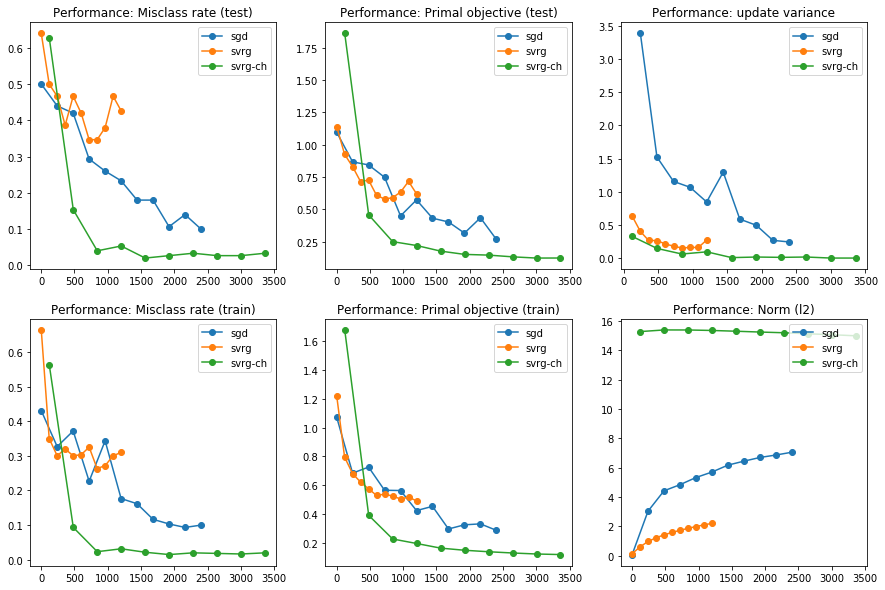

In [32]:

myfig = plt.figure(figsize=(15,10))


ax = myfig.add_subplot(2,3,1)
perf_idx = 1
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    
ax = myfig.add_subplot(2,3,2)
perf_idx = 3
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    
ax = myfig.add_subplot(2,3,3)
perf_idx = None
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")

    toread = os.path.join(results_dir, (al_name+".upvar"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_upvar = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_upvar, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: update variance")
    
    
ax = myfig.add_subplot(2,3,4)
perf_idx = 0
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    
ax = myfig.add_subplot(2,3,5)
perf_idx = 2
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])
    
    

ax = myfig.add_subplot(2,3,6)
perf_idx = 4
for al_name in names_methods:
    
    # First get the costs.
    toread = os.path.join(results_dir, (al_name+".cost"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_cost = np.loadtxt(fname=f, dtype=np.uint32, delimiter=",")
    
    toread = os.path.join(results_dir, (al_name+".ave"))
    with open(toread, mode="r", encoding="ascii") as f:
        toplot_ave = np.loadtxt(fname=f, dtype=np.float32, usecols=perf_idx, delimiter=",")
    ax.plot(toplot_cost, toplot_ave, "o-", label=al_name)
    ax.legend(loc=1,ncol=1)
    plt.title("Performance: "+perf_names[perf_idx])


plt.show()

___
